In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import os

# Obtain Stock Info

In [2]:
# Define the instruments to download (https://www.cnbc.com/berkshire-hathaway-portfolio/)
# tickers = ['TSLA', 'DVA', 'KHC', 'AXP', 'LSXMK', 'LSXMA', 'MCO' ,'BAC' ,'VRSN' ,'AXTA', 'USB', 'LBTYA', 'STOR', 'KO', 'RH', 'BK' ,'GL' ,'AAPL' ,'GM', 'LILA', 'STNE', 'TEVA', 'MTB', 'SYF', 'WFC', 'KR', 'CHTR', 'SNOW', 'LBTYK', 'PNC', 'SU', 'GOLD', 'SIRI', 'COST', 'LILAK', 'JPM', 'V', 'MA', 'BIIB', 'AMZN', 'MDLZ', 'PG', 'JNJ', 'VOO', 'UPS', 'SPY'] # Berkshire Hathaway's holdings
tickers = ["AAPL", "TSLA"]

# We would like all available data from 01/01/2010 until 10/10/2020
start_date = '2010-01-01'
end_date = '2020-10-19'


panel_data = yf.download(tickers, start_date, end_date)["Adj Close"] #ONLY INTERESTED IN ADJ CLOSE TO CONSIDER STOCK SPLITS

[*********************100%***********************]  2 of 2 completed


In [3]:
panel_data.tail()

AAPL        TSLA
Date                              
2020-10-12  122.712662  147.433334
2020-10-13  119.457428  148.883331
2020-10-14  119.546204  153.766663
2020-10-15  119.072716  149.626663
2020-10-16  117.405632  146.556671

# Q-Learning Build Up

In [4]:
import warnings
warnings.filterwarnings('ignore')

from keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model
from keras.regularizers import l2

import numpy as np
import pandas as pd

import random
from collections import deque
import matplotlib.pylab as plt

In [5]:
class Agent:
    def __init__(self, portfolio_size, is_eval = False, allow_short = True):
        self.portfolio_size = portfolio_size
        self.allow_short = allow_short
        self.input_shape = (portfolio_size, portfolio_size, )
        # 3 actions: hold, buy, sell
        # Michel, TODO: action size should be size of portfolio. Each action corresponds to
        # a stock and represents its weight in the portfolio at a time
        self.action_size = 3

        self.memory4replay = []
        self.is_eval = is_eval

        self.alpha = 0.75
        self.alpha_min = 0.2
        self.alpha_decay = 0.9

        self.gamma = 0.95
        self.gamma_min = 0.2
        self.gamma_decay = 0.9

        self.epsilon = 1
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.97

        self.model = self._model()

    def _model(self):
        inputs = Input(shape = self.input_shape)
        x = Flatten()(inputs)
        x = Dense(500, activation = 'softmax')(x)
        x = Dropout(0.5)(x)
        x = Dense(250, activation = 'softmax')(x)
        x = Dropout(0.5)(x)
        x = Dense(100, activation = 'softmax')(x)
        x = Dropout(0.5)(x)
        x = Dense(50, activation = 'softmax')(x)
        x = Dropout(0.5)(x)

        predictions = []
        for i in range(self.portfolio_size):
            # for each asset, go through each and choose among the three options
            asset_dense = Dense(self.action_size, activation = 'linear')(x)
            # append actions on preidcitions (probability in each action)
            predictions.append(asset_dense)

        model = Model(inputs=inputs, outputs = predictions)
        model.compile(optimizer = 'adam', loss = 'mse')

        return model
    
    # generate weight actions proportional to the predicted reward
    def nn_pred_to_weights(self, pred, allow_short = False):
        print("preds: ", pred)
        # pred is 3D array: n by 1 by a (n: number of stocks, a: number of actions)
        weights = np.zeros(len(pred))
        raw_weights = np.argmax(pred, axis = -1)
        saved_min = None
        for e, r in enumerate(raw_weights):
            if r == 0: weights[e] = 0
            # change so that the weights are not change, so the difference of the weights should be 0
            elif r == 1: weights[e] = np.abs(pred[e][0][r])
            else: weights[e] = -np.abs(pred[e][0][r])

        if not allow_short:
            weights += np.abs(np.min(weights))
            saved_min = np.abs(np.min(weights))
            saved_sum = np.sum(weights)
        else:
            saved_sum = np.sum(np.abs(weights))

        weights /= saved_sum
        return weights, saved_min, saved_sum

    def act(self, dms):
        #create local function that runs through the diagonal elements of the covariance matrix and gets weights that has non NaN values on the cov matrix
        # still need to work on conditions for shorting
        # What does -1  weight stand for? does it stand for selling all the stocks?
        # Then what's the total sum of the weight when shorting the stock?
        def randomweights(diagonal, shorting):
            # counting non-zero diagonal elements to get only public assets
            assetnum = np.count_nonzero(diagonal)
            # if we are not shorting, start with random weights between 0 and 1, their sum is 1
            if not shorting:
                _w = np.random.uniform(0, 1, assetnum)
                saved_sum = sum(_w)
                saved_min = None
                _w = (_w / sum(_w)).tolist()
            # if we are shorting, initialize weights between -1 and 1, their sum is 1
            # michel: why not initialize to any value
            else:
                _w = np.random.uniform(-1, 1, assetnum)
                saved_min = np.abs(np.min(_w))
                saved_sum = sum(_w)
                _w = (_w / sum(np.abs(_w))).tolist()

            n_weights = diagonal.copy()
            # this code can be further simplified by list comprehension
            for i in range(len(n_weights)):
                if n_weights[i] != 0:
                    n_weights[i] = _w.pop(0)

            return n_weights, saved_min, np.array(saved_sum)


        digele = np.diagonal(dms) #- the variances
        # Exploring option by giving random weights
        if not self.is_eval and random.random() <= self.epsilon:
#            print("epsilon: ", self.epsilon)
            rw, saved_min, saved_sum = randomweights(digele, self.allow_short)
            return rw, saved_min, saved_sum
        # create a separate model to see what the actual predictions should be
        pred = self.model.predict(np.expand_dims(dms.fillna(0).values, 0))
        return self.nn_pred_to_weights(pred, self.allow_short)

    def expReplay(self, batch_size):
            def weights_to_nn_preds_with_reward(action_weights, reward, Q_current_value, Q_star = np.zeros((self.portfolio_size, self.action_size))):
                Q = np.zeros((self.portfolio_size, self.action_size))
                for i in range(self.portfolio_size):
                    if action_weights[i] == 0:
                        Q[i][0] = reward[i] + self.gamma * np.max(Q_star[i])
                        Q[i][1] = Q_current_value[i][1]
                        Q[i][2] = Q_current_value[i][2]
                    elif action_weights[i] > 0:
                        Q[i][1] = reward[i] + self.gamma * np.max(Q_star[i])
                        Q[i][0] = Q_current_value[i][0]
                        Q[i][2] = Q_current_value[i][2]
                    else:
                        Q[i][2] = -reward[i] + self.gamma * np.max(Q_star[i])
                        Q[i][0] = Q_current_value[i][0]
                        Q[i][1] = Q_current_value[i][1]
                return Q

            def restore_Q_from_weights_and_stats(action):
                action_weights, action_min, action_sum = action[0], action[1], action[2]
                # why are we increasing the weights?
                action_weights = action_weights * action_sum
                if action_min != None:
                    action_weights = action_weights - action_min
                return action_weights

            for (s, s_, action, reward, done) in self.memory4replay:

                action_weights = restore_Q_from_weights_and_stats(action)
                Q_current_value = self.model.predict(np.expand_dims(s, 0))
                Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward, np.squeeze(Q_current_value))
                s, s_ = s.values, s_.values

                if not done:
                    Q_star = self.model.predict(np.expand_dims(s_, 0))
                    Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward, np.squeeze(Q_current_value), np.squeeze(Q_star))
                Q_learned_value = [xi.reshape(1, -1) for xi in Q_learned_value]

                Q = [np.add(a * (1-self.alpha), q * self.alpha) for a, q in zip(Q_current_value, Q_learned_value)]
                self.model.fit(np.expand_dims(s, 0), Q, epochs=1, verbose=0)

#            if self.alpha > self.alpha_min:
#                self.alpha *= self.alpha_decay
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

### Set Reward to Sharpe Ratio

In [13]:
def get_reward(action, action_t, reward_t, alpha = 0.01):

    def local_portfolio(returns, weights):
        average_returns = []
        for i in range(len(data_period.columns)):
            temp_return = np.log(data_period.T.values[i]).mean()
            average_returns.append(temp_return)


        weights = np.array(weights)
#         rets = returns.mean() # * 252
        covs = returns.cov() # * 252
#         P_ret = np.sum(rets * weights)
        P_ret = np.sum(np.array(pd.DataFrame(average_returns).fillna(0)).reshape((len(data_period.columns),)) * weights) #more accurate calculation of Portfolio Returns
        P_vol = np.sqrt(np.dot(weights.T, np.dot(covs, weights)))
#         P_sharpe = P_ret / P_vol
        P_sharpe = np.array(average_returns) / P_vol #obtain each stock SR based on Portfolio Volatility
        return np.array([P_ret, P_vol, P_sharpe])
    

    data_period = panel_data[action_t:reward_t]
    weights = action

    returns = np.log(data_period).diff().fillna(0) # ROY: Added diff() term
    sharpe = local_portfolio(returns, weights)[-1]
#     sharpe = np.array([sharpe] * len(panel_data.columns)) #
    rew = (data_period.values[-1] - data_period.values[0]) / data_period.values[0]
#     rew = sharpe

    return np.dot(returns, weights), rew #reward is Sharpe Ratio

In [17]:
state

AAPL        TSLA
Date                              
2010-01-04    6.515213         NaN
2010-01-05    6.526476         NaN
2010-01-06    6.422665         NaN
2010-01-07    6.410791         NaN
2010-01-08    6.453411         NaN
...                ...         ...
2020-10-12  122.712662  147.433334
2020-10-13  119.457428  148.883331
2020-10-14  119.546204  153.766663
2020-10-15  119.072716  149.626663
2020-10-16  117.405632  146.556671

[2717 rows x 2 columns]

In [31]:
state = panel_data.copy()
bstate = state.iloc[2000-360:2000]

# bstate[bstate.columns[bstate.pct_change()[1:].iloc[0] == 0]] = 0
bstate

AAPL       TSLA
Date                            
2016-07-11  22.452164  14.985333
2016-07-12  22.554029  14.976667
2016-07-13  22.426699  14.835333
2016-07-14  22.871206  14.768667
2016-07-15  22.868891  14.693333
...               ...        ...
2017-12-05  40.327656  20.246668
2017-12-06  40.177895  20.884001
2017-12-07  40.251595  20.749332
2017-12-08  40.263474  21.008667
2017-12-11  41.047962  21.927334

[360 rows x 2 columns]

In [26]:
bstate.columns[bstate.pct_change()[1:].iloc[0] == 0]

Index([], dtype='object')

In [7]:
def get_state(t, lookback, first_window, is_cov_matrix = True, is_raw_time_series = False ):
    def preprocess_state(state):
        return state

    assert lookback <= t
    state = panel_data.copy()
    if first_window:
        state = state.iloc[t-lookback:t]
    else:
        state = state.iloc[t-lookback-1:t]

    # this for-loop not necessary because it has noprice method
    for c in state.columns:
        if state[c].isna().any():
            state[c] = np.NaN

    #    decision_making_state = np.log(decision_making_state).fillna(0)
    #    decision_making_state = np.log(decision_making_state).fillna(0)
    state[state.columns[state.pct_change()[1:].iloc[0] == 0]] = 0
    decision_making_state = state.pct_change()[1:].fillna(0)

    if is_cov_matrix:
        return decision_making_state.cov()
    else:
        if is_raw_time_series:
            decision_making_state = panel_data.iloc[t-lookback:t]
        return preprocess_state(decision_making_state)

### Initialize Params

In [8]:
N_ASSETS = len(tickers)
agent = Agent(N_ASSETS, allow_short = False) # long only portfolio

Metal device set to: Apple M1 Max


2023-01-30 17:29:47.733962: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-30 17:29:47.734075: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
window_size = 360 #large window size due to large time-frame
episode_count = 15
batch_size = 32
rebalance_period = 30 #rebalance every month

### Run the Algo

In [30]:
np.random.randint(1, 5)

2

In [28]:
np.random.randint(window_size+1, data_length-window_size-1)

2027

Episode 0/15 epsilon 0.32400683201884195
preds:  [array([[ 0.03386633, -0.09546117,  0.05259334]], dtype=float32), array([[-0.04814413,  0.00571106,  0.05237192]], dtype=float32)]
preds:  [array([[ 0.03386633, -0.09546117,  0.05259334]], dtype=float32), array([[-0.04814413,  0.00571106,  0.05237192]], dtype=float32)]
preds:  [array([[ 0.03386633, -0.09546117,  0.05259334]], dtype=float32), array([[-0.04814413,  0.00571106,  0.05237192]], dtype=float32)]
preds:  [array([[ 0.03386633, -0.09546117,  0.05259334]], dtype=float32), array([[-0.04814413,  0.00571106,  0.05237192]], dtype=float32)]
preds:  [array([[ 0.03386633, -0.09546117,  0.05259334]], dtype=float32), array([[-0.04814413,  0.00571106,  0.05237192]], dtype=float32)]
preds:  [array([[ 0.03386633, -0.09546117,  0.05259334]], dtype=float32), array([[-0.04814413,  0.00571106,  0.05237192]], dtype=float32)]
preds:  [array([[ 0.03386633, -0.09546117,  0.05259334]], dtype=float32), array([[-0.04814413,  0.00571106,  0.05237192]], dt

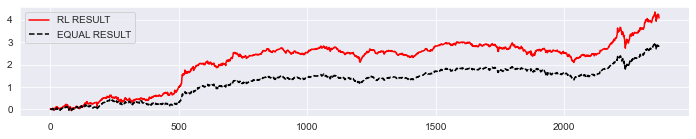

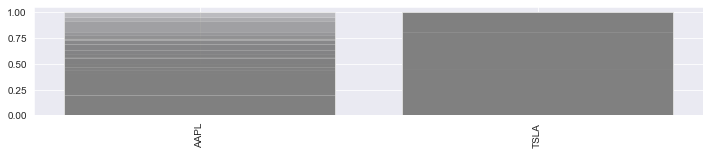

Episode 1/15 epsilon 0.3048580282465284
preds:  [array([[ 0.02449925, -0.08620696,  0.05239458]], dtype=float32), array([[-0.04332414,  0.00731804,  0.05235828]], dtype=float32)]
preds:  [array([[ 0.02449925, -0.08620696,  0.05239458]], dtype=float32), array([[-0.04332414,  0.00731804,  0.05235828]], dtype=float32)]
preds:  [array([[ 0.02449925, -0.08620696,  0.05239458]], dtype=float32), array([[-0.04332414,  0.00731804,  0.05235828]], dtype=float32)]
preds:  [array([[ 0.02449925, -0.08620696,  0.05239458]], dtype=float32), array([[-0.04332414,  0.00731804,  0.05235828]], dtype=float32)]
preds:  [array([[ 0.02449925, -0.08620696,  0.05239458]], dtype=float32), array([[-0.04332414,  0.00731804,  0.05235828]], dtype=float32)]
preds:  [array([[ 0.02449925, -0.08620696,  0.05239458]], dtype=float32), array([[-0.04332414,  0.00731804,  0.05235828]], dtype=float32)]
preds:  [array([[ 0.02449925, -0.08620696,  0.05239458]], dtype=float32), array([[-0.04332414,  0.00731804,  0.05235828]], dty

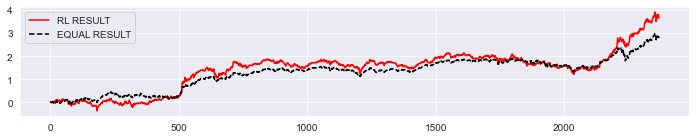

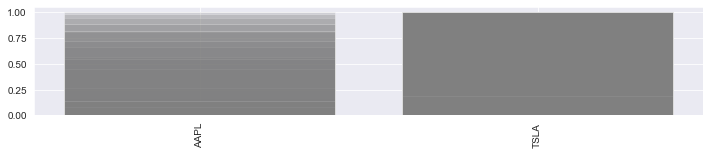

Episode 2/15 epsilon 0.2868409187771586
preds:  [array([[ 0.03739233, -0.1142177 ,  0.0525839 ]], dtype=float32), array([[-0.04719786,  0.00684238,  0.0524541 ]], dtype=float32)]
preds:  [array([[ 0.03739233, -0.1142177 ,  0.0525839 ]], dtype=float32), array([[-0.04719786,  0.00684238,  0.0524541 ]], dtype=float32)]
preds:  [array([[ 0.03739233, -0.1142177 ,  0.0525839 ]], dtype=float32), array([[-0.04719786,  0.00684238,  0.0524541 ]], dtype=float32)]
preds:  [array([[ 0.03739233, -0.1142177 ,  0.0525839 ]], dtype=float32), array([[-0.04719786,  0.00684238,  0.0524541 ]], dtype=float32)]
preds:  [array([[ 0.03739233, -0.1142177 ,  0.0525839 ]], dtype=float32), array([[-0.04719786,  0.00684238,  0.0524541 ]], dtype=float32)]
preds:  [array([[ 0.03739233, -0.1142177 ,  0.0525839 ]], dtype=float32), array([[-0.04719786,  0.00684238,  0.0524541 ]], dtype=float32)]
preds:  [array([[ 0.03739233, -0.1142177 ,  0.0525839 ]], dtype=float32), array([[-0.04719786,  0.00684238,  0.0524541 ]], dty

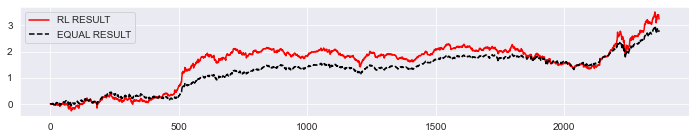

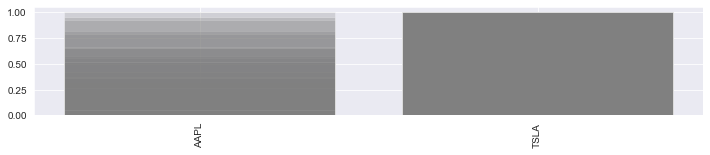

Episode 3/15 epsilon 0.26179196186310566
preds:  [array([[ 0.03692478, -0.12468411,  0.05312034]], dtype=float32), array([[-0.04937668,  0.00759972,  0.05302547]], dtype=float32)]
preds:  [array([[ 0.03692478, -0.12468411,  0.05312034]], dtype=float32), array([[-0.04937668,  0.00759972,  0.05302547]], dtype=float32)]
preds:  [array([[ 0.03692478, -0.12468411,  0.05312034]], dtype=float32), array([[-0.04937668,  0.00759972,  0.05302547]], dtype=float32)]
preds:  [array([[ 0.03692478, -0.12468411,  0.05312034]], dtype=float32), array([[-0.04937668,  0.00759972,  0.05302547]], dtype=float32)]
preds:  [array([[ 0.03692478, -0.12468411,  0.05312034]], dtype=float32), array([[-0.04937668,  0.00759972,  0.05302547]], dtype=float32)]
preds:  [array([[ 0.03692478, -0.12468411,  0.05312034]], dtype=float32), array([[-0.04937668,  0.00759972,  0.05302547]], dtype=float32)]
preds:  [array([[ 0.03692478, -0.12468411,  0.05312034]], dtype=float32), array([[-0.04937668,  0.00759972,  0.05302547]], dt

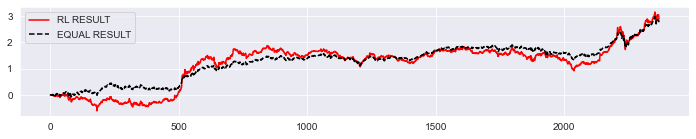

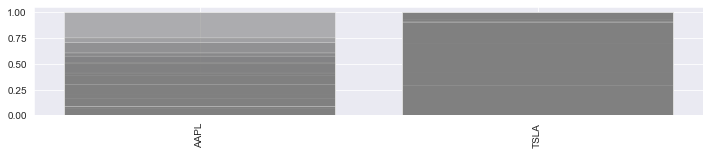

Episode 4/15 epsilon 0.2463200569169961
preds:  [array([[ 0.03766236, -0.1234045 ,  0.05377067]], dtype=float32), array([[-0.03748513,  0.01206302,  0.05331135]], dtype=float32)]
preds:  [array([[ 0.03766236, -0.1234045 ,  0.05377067]], dtype=float32), array([[-0.03748513,  0.01206302,  0.05331135]], dtype=float32)]
preds:  [array([[ 0.03766236, -0.1234045 ,  0.05377067]], dtype=float32), array([[-0.03748513,  0.01206302,  0.05331135]], dtype=float32)]
preds:  [array([[ 0.03566515, -0.11416727,  0.05260183]], dtype=float32), array([[-0.04647882,  0.00878438,  0.05279991]], dtype=float32)]
preds:  [array([[ 0.03566515, -0.11416727,  0.05260183]], dtype=float32), array([[-0.04647882,  0.00878438,  0.05279991]], dtype=float32)]
preds:  [array([[ 0.03566515, -0.11416727,  0.05260183]], dtype=float32), array([[-0.04647882,  0.00878438,  0.05279991]], dtype=float32)]
preds:  [array([[ 0.03566515, -0.11416727,  0.05260183]], dtype=float32), array([[-0.04647882,  0.00878438,  0.05279991]], dty

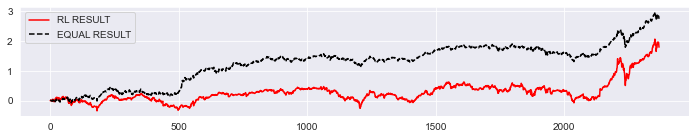

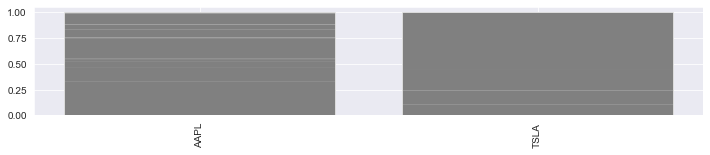

Episode 5/15 epsilon 0.2248096653066056
preds:  [array([[ 0.02196474, -0.07342571,  0.05326045]], dtype=float32), array([[ 0.02882775, -0.01285363,  0.05317638]], dtype=float32)]
preds:  [array([[ 0.02196474, -0.07342571,  0.05326045]], dtype=float32), array([[ 0.02882775, -0.01285363,  0.05317638]], dtype=float32)]
preds:  [array([[ 0.02196474, -0.07342571,  0.05326045]], dtype=float32), array([[ 0.02882775, -0.01285363,  0.05317638]], dtype=float32)]
preds:  [array([[ 0.02196474, -0.07342571,  0.05326045]], dtype=float32), array([[ 0.02882775, -0.01285363,  0.05317638]], dtype=float32)]
preds:  [array([[ 0.02196474, -0.07342571,  0.05326045]], dtype=float32), array([[ 0.02882775, -0.01285363,  0.05317638]], dtype=float32)]
preds:  [array([[ 0.02196474, -0.07342571,  0.05326045]], dtype=float32), array([[ 0.02882775, -0.01285363,  0.05317638]], dtype=float32)]
preds:  [array([[ 0.02196474, -0.07342571,  0.05326045]], dtype=float32), array([[ 0.02882775, -0.01285363,  0.05317638]], dty

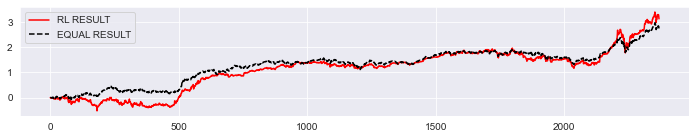

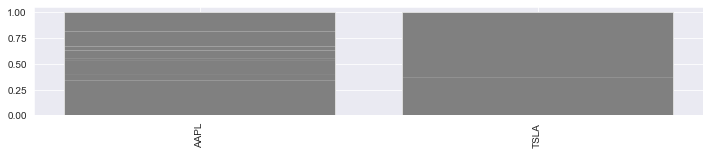

Episode 6/15 epsilon 0.2115234140869852
preds:  [array([[ 0.01443021, -0.05506825,  0.05255599]], dtype=float32), array([[ 0.01670794, -0.0073007 ,  0.0522469 ]], dtype=float32)]
preds:  [array([[ 0.01443021, -0.05506825,  0.05255599]], dtype=float32), array([[ 0.01670794, -0.0073007 ,  0.0522469 ]], dtype=float32)]
preds:  [array([[ 0.01443021, -0.05506825,  0.05255599]], dtype=float32), array([[ 0.01670794, -0.0073007 ,  0.0522469 ]], dtype=float32)]
preds:  [array([[ 0.01443021, -0.05506825,  0.05255599]], dtype=float32), array([[ 0.01670794, -0.0073007 ,  0.0522469 ]], dtype=float32)]
preds:  [array([[ 0.01474321, -0.05665534,  0.05150648]], dtype=float32), array([[ 0.00689318, -0.00885816,  0.05165975]], dtype=float32)]
preds:  [array([[ 0.01474321, -0.05665534,  0.05150648]], dtype=float32), array([[ 0.00689318, -0.00885816,  0.05165975]], dtype=float32)]
preds:  [array([[ 0.01474321, -0.05665534,  0.05150648]], dtype=float32), array([[ 0.00689318, -0.00885816,  0.05165975]], dty

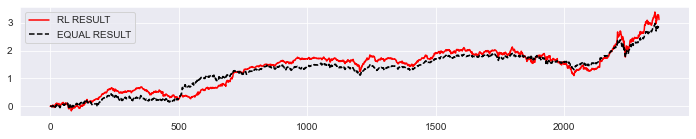

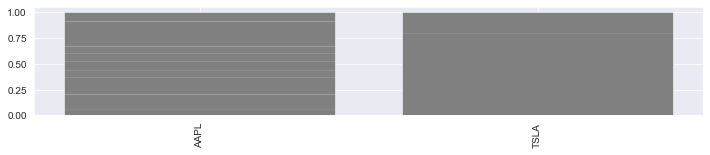

Episode 7/15 epsilon 0.19305170890501103
preds:  [array([[ 0.01123191, -0.05547718,  0.0517427 ]], dtype=float32), array([[ 0.01695802, -0.0208899 ,  0.0517297 ]], dtype=float32)]
preds:  [array([[ 0.01123191, -0.05547718,  0.0517427 ]], dtype=float32), array([[ 0.01695802, -0.0208899 ,  0.0517297 ]], dtype=float32)]
preds:  [array([[ 0.01123191, -0.05547718,  0.0517427 ]], dtype=float32), array([[ 0.01695802, -0.0208899 ,  0.0517297 ]], dtype=float32)]
preds:  [array([[ 0.01123191, -0.05547718,  0.0517427 ]], dtype=float32), array([[ 0.01695802, -0.0208899 ,  0.0517297 ]], dtype=float32)]
preds:  [array([[ 0.01123191, -0.05547718,  0.0517427 ]], dtype=float32), array([[ 0.01695802, -0.0208899 ,  0.0517297 ]], dtype=float32)]
preds:  [array([[ 0.01123191, -0.05547718,  0.0517427 ]], dtype=float32), array([[ 0.01695802, -0.0208899 ,  0.0517297 ]], dtype=float32)]
preds:  [array([[ 0.01123191, -0.05547718,  0.0517427 ]], dtype=float32), array([[ 0.01695802, -0.0208899 ,  0.0517297 ]], dt

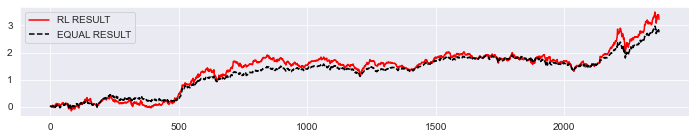

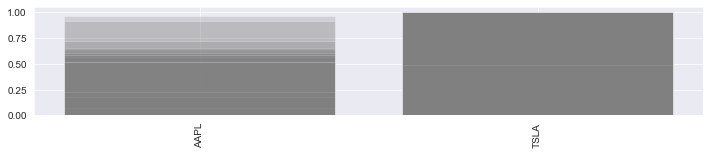

Episode 8/15 epsilon 0.18164235290872485
preds:  [array([[ 0.03066421, -0.09348432,  0.05171876]], dtype=float32), array([[-0.01697346, -0.00076521,  0.05146981]], dtype=float32)]
preds:  [array([[ 0.03066421, -0.09348432,  0.05171876]], dtype=float32), array([[-0.01697346, -0.00076521,  0.05146981]], dtype=float32)]
preds:  [array([[ 0.03066421, -0.09348432,  0.05171876]], dtype=float32), array([[-0.01697346, -0.00076521,  0.05146981]], dtype=float32)]
preds:  [array([[ 0.03066421, -0.09348432,  0.05171876]], dtype=float32), array([[-0.01697346, -0.00076521,  0.05146981]], dtype=float32)]
preds:  [array([[ 0.03066421, -0.09348432,  0.05171876]], dtype=float32), array([[-0.01697346, -0.00076521,  0.05146981]], dtype=float32)]
preds:  [array([[ 0.03066421, -0.09348432,  0.05171876]], dtype=float32), array([[-0.01697346, -0.00076521,  0.05146981]], dtype=float32)]
preds:  [array([[ 0.03066421, -0.09348432,  0.05171876]], dtype=float32), array([[-0.01697346, -0.00076521,  0.05146981]], dt

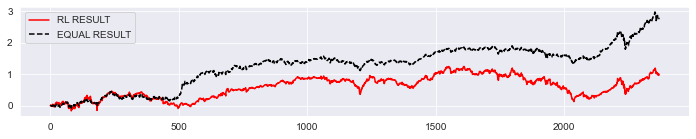

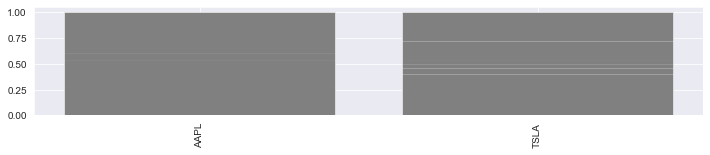

Episode 9/15 epsilon 0.16578007115626464
preds:  [array([[ 0.02423959, -0.0829302 ,  0.05173982]], dtype=float32), array([[ 0.00938236, -0.01769305,  0.05174966]], dtype=float32)]
preds:  [array([[ 0.02423959, -0.0829302 ,  0.05173982]], dtype=float32), array([[ 0.00938236, -0.01769305,  0.05174966]], dtype=float32)]
preds:  [array([[ 0.02423959, -0.0829302 ,  0.05173982]], dtype=float32), array([[ 0.00938236, -0.01769305,  0.05174966]], dtype=float32)]
preds:  [array([[ 0.02423959, -0.0829302 ,  0.05173982]], dtype=float32), array([[ 0.00938236, -0.01769305,  0.05174966]], dtype=float32)]
preds:  [array([[ 0.02423959, -0.0829302 ,  0.05173982]], dtype=float32), array([[ 0.00938236, -0.01769305,  0.05174966]], dtype=float32)]
preds:  [array([[ 0.02423959, -0.0829302 ,  0.05173982]], dtype=float32), array([[ 0.00938236, -0.01769305,  0.05174966]], dtype=float32)]
preds:  [array([[ 0.02423959, -0.0829302 ,  0.05173982]], dtype=float32), array([[ 0.00938236, -0.01769305,  0.05174966]], dt

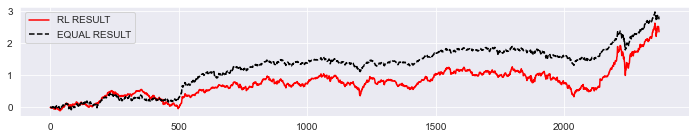

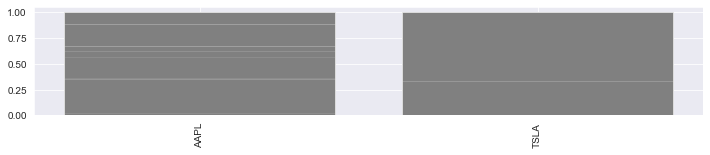

Episode 10/15 epsilon 0.1559824689509294
preds:  [array([[ 0.01408968, -0.0616493 ,  0.05217259]], dtype=float32), array([[ 0.03940461, -0.02780642,  0.05207402]], dtype=float32)]
preds:  [array([[ 0.01408968, -0.0616493 ,  0.05217259]], dtype=float32), array([[ 0.03940461, -0.02780642,  0.05207402]], dtype=float32)]
preds:  [array([[ 0.01408968, -0.0616493 ,  0.05217259]], dtype=float32), array([[ 0.03940461, -0.02780642,  0.05207402]], dtype=float32)]
preds:  [array([[ 0.01408968, -0.0616493 ,  0.05217259]], dtype=float32), array([[ 0.03940461, -0.02780642,  0.05207402]], dtype=float32)]
preds:  [array([[ 0.01408968, -0.0616493 ,  0.05217259]], dtype=float32), array([[ 0.03940461, -0.02780642,  0.05207402]], dtype=float32)]
preds:  [array([[ 0.01408968, -0.0616493 ,  0.05217259]], dtype=float32), array([[ 0.03940461, -0.02780642,  0.05207402]], dtype=float32)]
preds:  [array([[ 0.01408968, -0.0616493 ,  0.05217259]], dtype=float32), array([[ 0.03940461, -0.02780642,  0.05207402]], dt

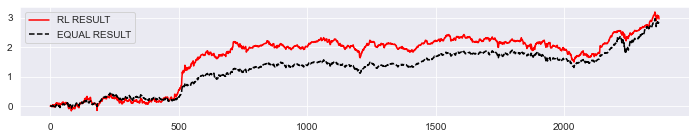

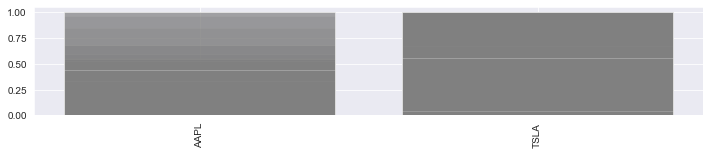

Episode 11/15 epsilon 0.14236098788485158
preds:  [array([[ 0.02680054, -0.10624495,  0.05071957]], dtype=float32), array([[-0.01294834, -0.01012535,  0.05075485]], dtype=float32)]
preds:  [array([[ 0.02680054, -0.10624495,  0.05071957]], dtype=float32), array([[-0.01294834, -0.01012535,  0.05075485]], dtype=float32)]
preds:  [array([[ 0.02680054, -0.10624495,  0.05071957]], dtype=float32), array([[-0.01294834, -0.01012535,  0.05075485]], dtype=float32)]
preds:  [array([[ 0.02680054, -0.10624495,  0.05071957]], dtype=float32), array([[-0.01294834, -0.01012535,  0.05075485]], dtype=float32)]
preds:  [array([[ 0.02680054, -0.10624495,  0.05071957]], dtype=float32), array([[-0.01294834, -0.01012535,  0.05075485]], dtype=float32)]
preds:  [array([[ 0.02680054, -0.10624495,  0.05071957]], dtype=float32), array([[-0.01294834, -0.01012535,  0.05075485]], dtype=float32)]
preds:  [array([[ 0.02680054, -0.10624495,  0.05071957]], dtype=float32), array([[-0.01294834, -0.01012535,  0.05075485]], d

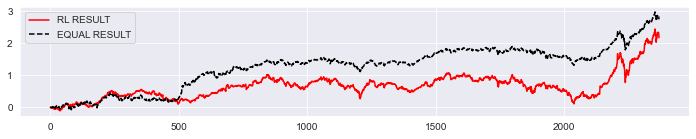

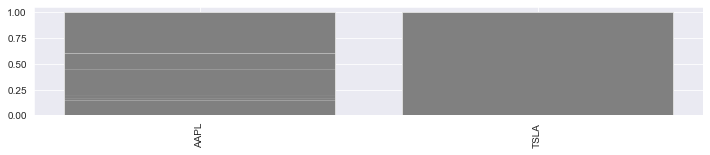

Episode 12/15 epsilon 0.13394745350085685
preds:  [array([[ 0.02115772, -0.07894086,  0.05173226]], dtype=float32), array([[ 0.02621964, -0.01976475,  0.05135566]], dtype=float32)]
preds:  [array([[ 0.02115772, -0.07894086,  0.05173226]], dtype=float32), array([[ 0.02621964, -0.01976475,  0.05135566]], dtype=float32)]
preds:  [array([[ 0.02115772, -0.07894086,  0.05173226]], dtype=float32), array([[ 0.02621964, -0.01976475,  0.05135566]], dtype=float32)]
preds:  [array([[ 0.02115772, -0.07894086,  0.05173226]], dtype=float32), array([[ 0.02621964, -0.01976475,  0.05135566]], dtype=float32)]
preds:  [array([[ 0.02115772, -0.07894086,  0.05173226]], dtype=float32), array([[ 0.02621964, -0.01976475,  0.05135566]], dtype=float32)]
preds:  [array([[ 0.02115772, -0.07894086,  0.05173226]], dtype=float32), array([[ 0.02621964, -0.01976475,  0.05135566]], dtype=float32)]
preds:  [array([[ 0.02115772, -0.07894086,  0.05173226]], dtype=float32), array([[ 0.02621964, -0.01976475,  0.05135566]], d

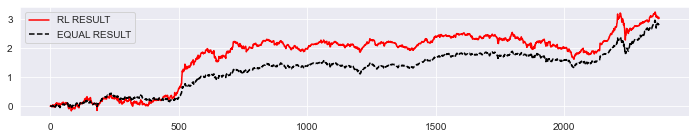

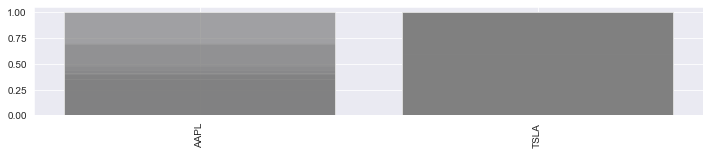

Episode 13/15 epsilon 0.12225022422898751
preds:  [array([[ 0.03251842, -0.12796944,  0.05060899]], dtype=float32), array([[-0.01588052, -0.00635877,  0.05071553]], dtype=float32)]
preds:  [array([[ 0.03251842, -0.12796944,  0.05060899]], dtype=float32), array([[-0.01588052, -0.00635877,  0.05071553]], dtype=float32)]
preds:  [array([[ 0.03251842, -0.12796944,  0.05060899]], dtype=float32), array([[-0.01588052, -0.00635877,  0.05071553]], dtype=float32)]
preds:  [array([[ 0.03251842, -0.12796944,  0.05060899]], dtype=float32), array([[-0.01588052, -0.00635877,  0.05071553]], dtype=float32)]
preds:  [array([[ 0.03251842, -0.12796944,  0.05060899]], dtype=float32), array([[-0.01588052, -0.00635877,  0.05071553]], dtype=float32)]
preds:  [array([[ 0.03251842, -0.12796944,  0.05060899]], dtype=float32), array([[-0.01588052, -0.00635877,  0.05071553]], dtype=float32)]
preds:  [array([[ 0.03251842, -0.12796944,  0.05060899]], dtype=float32), array([[-0.01588052, -0.00635877,  0.05071553]], d

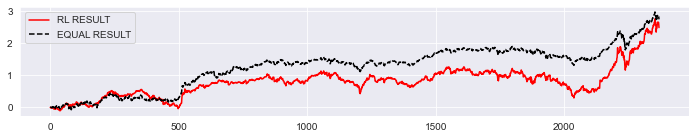

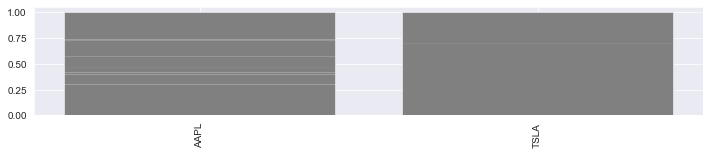

Episode 14/15 epsilon 0.11502523597705434
preds:  [array([[ 0.02010241, -0.08147901,  0.05090734]], dtype=float32), array([[ 0.02727557, -0.02155235,  0.05076691]], dtype=float32)]
preds:  [array([[ 0.02010241, -0.08147901,  0.05090734]], dtype=float32), array([[ 0.02727557, -0.02155235,  0.05076691]], dtype=float32)]
preds:  [array([[ 0.02010241, -0.08147901,  0.05090734]], dtype=float32), array([[ 0.02727557, -0.02155235,  0.05076691]], dtype=float32)]
preds:  [array([[ 0.02010241, -0.08147901,  0.05090734]], dtype=float32), array([[ 0.02727557, -0.02155235,  0.05076691]], dtype=float32)]
preds:  [array([[ 0.02010241, -0.08147901,  0.05090734]], dtype=float32), array([[ 0.02727557, -0.02155235,  0.05076691]], dtype=float32)]
preds:  [array([[ 0.02010241, -0.08147901,  0.05090734]], dtype=float32), array([[ 0.02727557, -0.02155235,  0.05076691]], dtype=float32)]
preds:  [array([[ 0.02010241, -0.08147901,  0.05090734]], dtype=float32), array([[ 0.02727557, -0.02155235,  0.05076691]], d

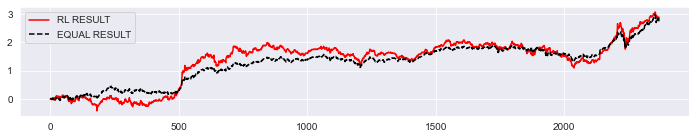

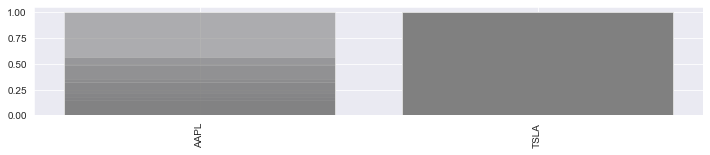

In [14]:
for e in range(episode_count):
    
    agent.is_eval = False
    data_length = len(panel_data)

    returns_history = []
    returns_history_equal = []
    
    rewards_history = []
    equal_rewards = []
    
    actions_to_show = []
    
    print("Episode " + str(e) + "/" + str(episode_count), 'epsilon', agent.epsilon)

    s = get_state(np.random.randint(window_size+1, data_length-window_size-1), window_size, first_window = False) #generate price dataset of given time interval
    total_profit = 0 

    for t in range(window_size, data_length, rebalance_period):
        if t == window_size:
            first_window = True
        else:
            first_window = False
        date1 = t-rebalance_period
        
        s_ = get_state(t, window_size, first_window) # obtains dataset df - covariance matrix of returns
        action = agent.act(s_) # obtains the weights of the portfolio, minimum weight %, sum of weights
        
        actions_to_show.append(action[0]) # append the weights
    
        temp_reward = get_reward(action[0], date1, t) # gets the reward (returns of the portfolio and/or the SR)
        weighted_returns = np.nan_to_num(temp_reward[0], 0) # replace NaN -> 0, infinity-> large finite numbers
        reward = np.nan_to_num(temp_reward[1], 0)

#         weighted_returns, reward = np.nan_to_num(get_reward(action[0], date1, t), 0) #obtain reward
        weighted_returns_equal, reward_equal = get_reward(
            np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t) # get reward for equal weighted portfolio

        rewards_history.append(reward) # append reward to the history list
#         print("REWARD: {}".format(reward))
        equal_rewards.append(reward_equal)
        returns_history.extend(weighted_returns) # extend returns_history list with weighted returns
        returns_history_equal.extend(weighted_returns_equal) # same for equal weighted portfolio

        done = True if t == data_length else False # stop if reached the end of data
        agent.memory4replay.append((s, s_, action, reward, done)) # feed Q function updated parameters
        
        if len(agent.memory4replay) >= batch_size:
            agent.expReplay(batch_size) #apply Q-function and update params
            agent.memory4replay = []
            
        s = s_ #update dataset with new timeframe

    print("REWARD: {}".format(np.array(rewards_history).max()))

    ### PLOT RETURNS OF WEIGHTED VS EQUAL ###
    rl_result = np.array(returns_history).cumsum()
    equal_result = np.array(returns_history_equal).cumsum()

    plt.figure(figsize = (12, 2))
    plt.plot(rl_result, color = 'red', ls = '-', label= "RL RESULT")
    plt.plot(equal_result, color = 'black', ls = '--', label = "EQUAL RESULT")
    plt.legend()
    plt.show()
    
    
    plt.figure(figsize = (12, 2))
    for a in actions_to_show:    
        plt.bar(np.arange(N_ASSETS), a, color = 'grey', alpha = 0.25)
        plt.xticks(np.arange(N_ASSETS), panel_data.columns, rotation='vertical')
    plt.show()
    

# Evaluating agent

In [33]:
agent.is_eval = True # now we will evaluate the agent

actions_equal, actions_rl = [], []
result_equal, result_rl = [], []

for t in range(window_size, len(panel_data), rebalance_period):
    if t == window_size:
        first_window = True
    else:
        first_window = False

    date1 = t-rebalance_period
    s_ = get_state(t, window_size, first_window) #obtain price dataset of given time interval
    action = agent.act(s_) # obtain weights, min weight %, sum of weights

    weighted_returns, reward = get_reward(action[0], date1, t) #obtain weighted returns and rewards
    weighted_returns_equal, reward_equal = get_reward(
        np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t) # same for equal weighted portfolio

    result_equal.append(weighted_returns_equal.tolist()) # append list of weights in timeframe to an array
    actions_equal.append(np.ones(agent.portfolio_size) / agent.portfolio_size) # same with equal weighted portfolio
    
    result_rl.append(weighted_returns.tolist()) # append RL returns list to an array corresponding to each timeframe
    actions_rl.append(action[0]) # append RL weights

preds:  [array([[ 0.03494661, -0.13288558,  0.05009041]], dtype=float32), array([[-0.01294971, -0.00655068,  0.05025791]], dtype=float32)]
preds:  [array([[ 0.03494661, -0.13288558,  0.05009041]], dtype=float32), array([[-0.01294971, -0.00655068,  0.05025791]], dtype=float32)]
preds:  [array([[ 0.03494661, -0.13288558,  0.05009041]], dtype=float32), array([[-0.01294971, -0.00655068,  0.05025791]], dtype=float32)]
preds:  [array([[ 0.03494661, -0.13288558,  0.05009041]], dtype=float32), array([[-0.01294971, -0.00655068,  0.05025791]], dtype=float32)]
preds:  [array([[ 0.03494661, -0.13288558,  0.05009041]], dtype=float32), array([[-0.01294971, -0.00655068,  0.05025791]], dtype=float32)]
preds:  [array([[ 0.03494661, -0.13288558,  0.05009041]], dtype=float32), array([[-0.01294971, -0.00655068,  0.05025791]], dtype=float32)]
preds:  [array([[ 0.03494661, -0.13288558,  0.05009041]], dtype=float32), array([[-0.01294971, -0.00655068,  0.05025791]], dtype=float32)]
preds:  [array([[ 0.0349466

In [34]:
import statsmodels.api as sm
from statsmodels import regression

def sharpe(R): #Sharpe Ratio Formula and assuming risk free rate = 0
    r = np.diff(R)
    sr = r.mean()/r.std() * np.sqrt(252)
    return sr

def print_stats(result, benchmark): #benchmark will be the equally weighted portfolio (might change it to SPY)

    sharpe_ratio = sharpe(np.array(result).cumsum()) # obtain SR
    returns = np.mean(np.array(result)) # obtain returns
    volatility = np.std(np.array(result)) # obtain volatility

    X = benchmark
    y = result
    x = sm.add_constant(X)
    model = regression.linear_model.OLS(y, x).fit()
    alpha = model.params[0]
    beta = model.params[1]

    return np.round(np.array([returns, volatility, sharpe_ratio, alpha, beta]), 4).tolist()

In [35]:
result_equal_vis = [item for sublist in result_equal for item in sublist] # equal portfolio returns
result_rl_vis = [item for sublist in result_rl for item in sublist] # same for RL
### THESE VALUES ARE IN % RETURN ###

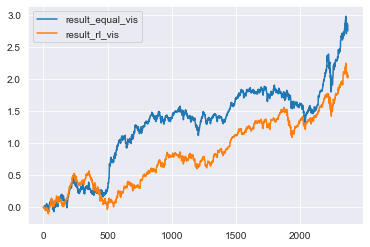

In [36]:
plt.figure()
plt.plot(np.array(result_equal_vis).cumsum(), label = 'result_equal_vis')
plt.plot(np.array(result_rl_vis).cumsum(), label = 'result_rl_vis')
plt.legend()
plt.show()

In [37]:
EQUAL = print_stats(result_equal_vis, result_equal_vis)
RL_AGENT = print_stats(result_rl_vis, result_equal_vis)

print(f'EQUAL:\nRET: {EQUAL[0]}, VOL: {EQUAL[1]}, SR: {EQUAL[2]}, ALPHA: {EQUAL[3]}, BETA: {EQUAL[4]}') # try weighting against a complete spy portfolio not equally weighted
print(f'RL AGENT:\nRET: {RL_AGENT[0]}, VOL: {RL_AGENT[1]}, SR: {RL_AGENT[2]}, ALPHA: {RL_AGENT[3]}, BETA: {RL_AGENT[4]}') 


EQUAL:
RET: 0.0012, VOL: 0.0216, SR: 0.853, ALPHA: 0.0, BETA: 1.0
RL AGENT:
RET: 0.0009, VOL: 0.0177, SR: 0.7661, ALPHA: 0.0002, BETA: 0.544


### Save GIFS/PHOTOS

In [39]:
import matplotlib
def plot_results(benchmark_series,
                 target_series,
                 target_balances,
                 n_assets,
                 columns,
                 name2plot = '',
                 path2save = './',
                 base_name_series = 'series'):

#     N = len(np.array(benchmark_series).cumsum())
    N = len(np.array([item for sublist in benchmark_series for item in sublist]).cumsum())

    if not os.path.exists(path2save):
        os.makedirs(path2save)

    for i in range(0, len(target_balances)):

        current_range = np.arange(0, N)
        current_ts = np.zeros(N)
        current_ts2 = np.zeros(N)

        # cumulative returns for a given time period
        ts_benchmark = np.array([item for sublist in benchmark_series[:i+1] for item in sublist]).cumsum() 
        ts_target = np.array([item for sublist in target_series[:i+1] for item in sublist]).cumsum()

        # update time period
        t = len(ts_benchmark)
        current_ts[:t] = ts_benchmark
        current_ts2[:t] = ts_target

        # change zeroes in initialization array to cumulative return of a given time period
        current_ts[current_ts == 0] = ts_benchmark[-1]
        current_ts2[current_ts2 == 0] = ts_target[-1]

        ### PLOT THE RETURNS FOR A GIVEN TIME PERIOD ###
        plt.figure(figsize = (12, 10))

        plt.subplot(2, 1, 1)
        plt.bar(np.arange(n_assets), target_balances[i], color = 'grey')
        plt.xticks(np.arange(n_assets), columns, rotation='vertical')
        plt.ylabel(["Weights"])
        

        plt.subplot(2, 1, 2)
        current_cmap = matplotlib.cm.get_cmap()
        current_cmap.set_bad(color='red')
        plt.colormaps = current_cmap
        plt.plot(current_range[:t], current_ts[:t], color = 'black', label = 'Benchmark')
        plt.plot(current_range[:t], current_ts2[:t], color = 'red', label = name2plot)
        plt.plot(current_range[t:], current_ts[t:], ls = '--', lw = .1, color = 'black')
#         plt.autoscale(False)
#         plt.ylim([-1, 1])
        plt.legend()
        # plt.savefig(path2save + base_name_series + str(i) + '.jpg')

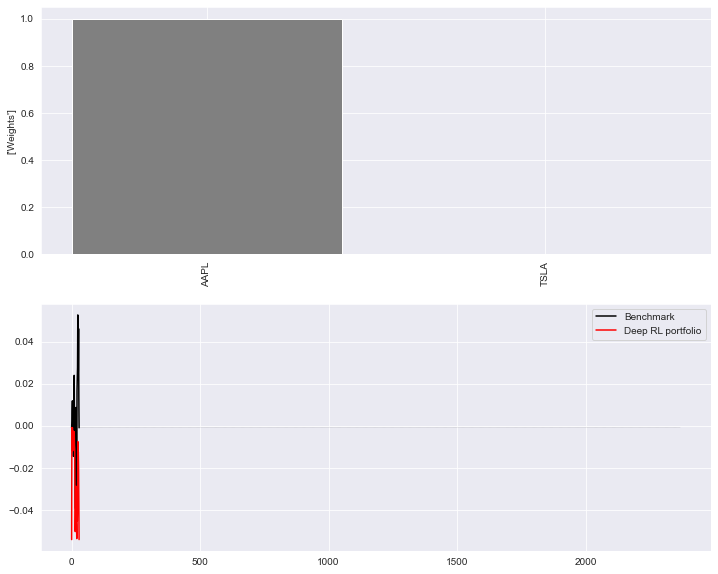

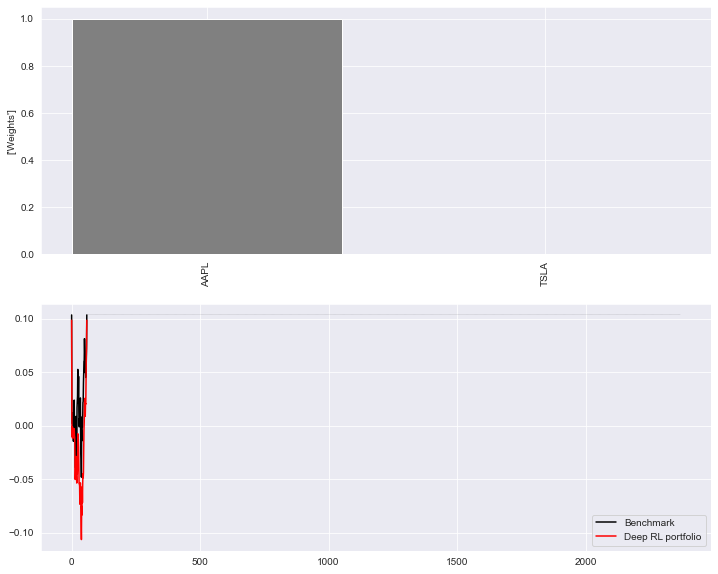

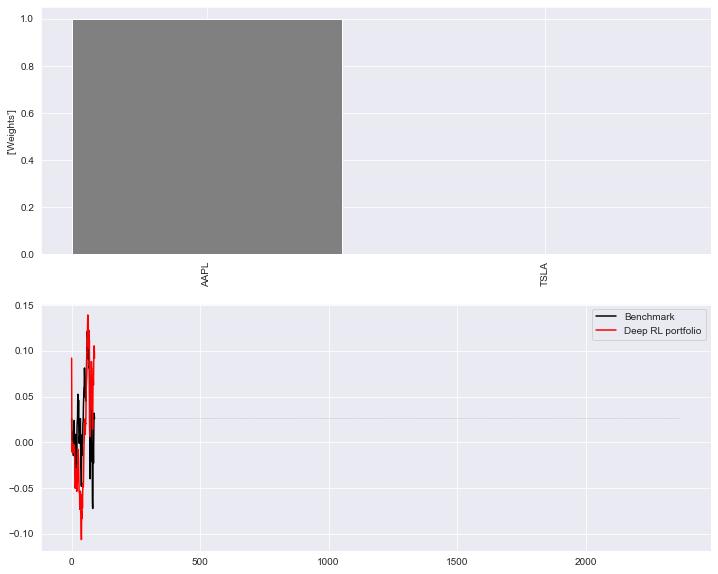

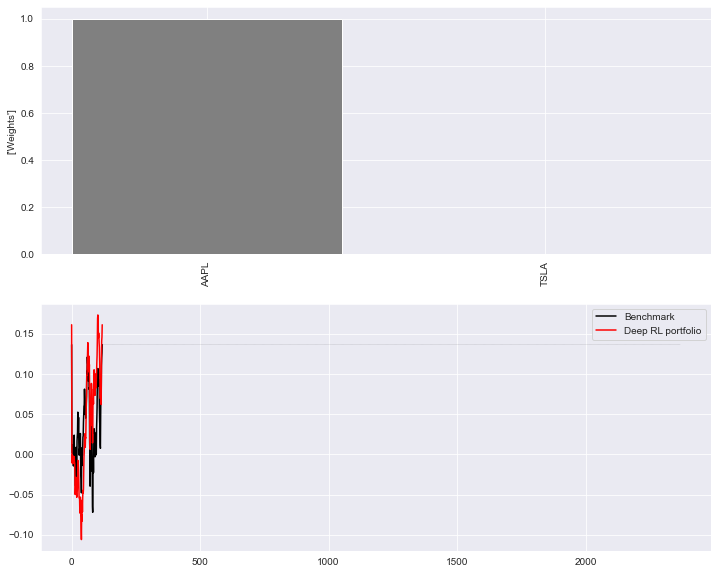

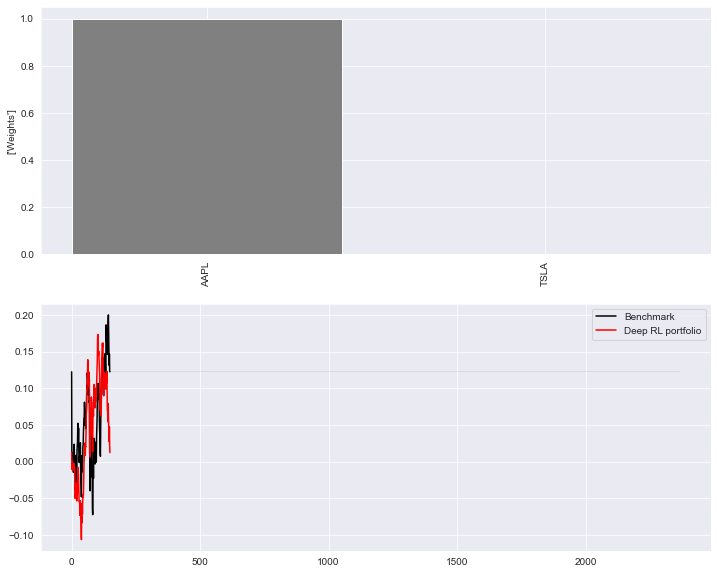

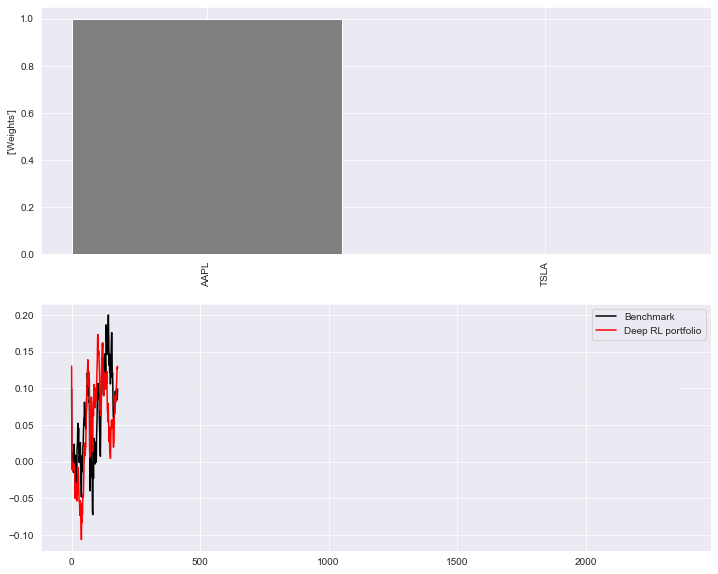

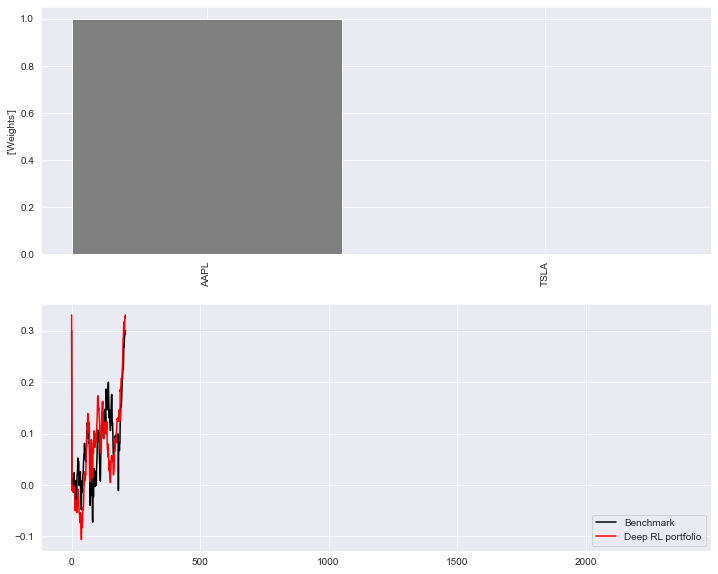

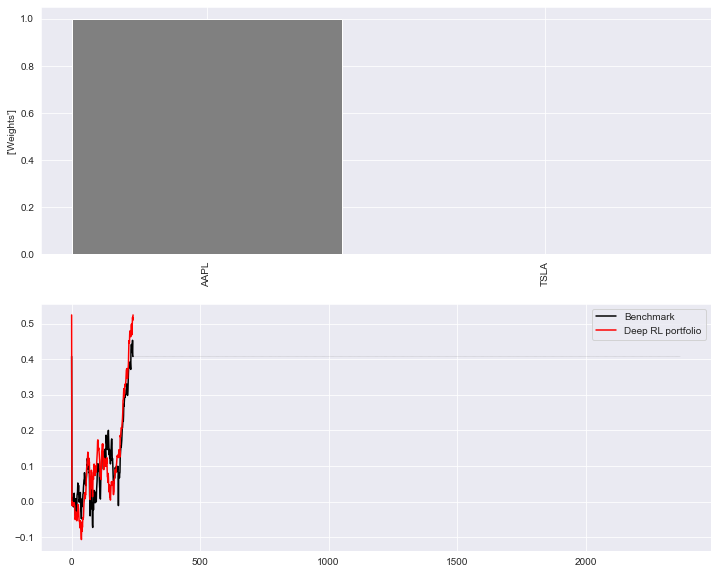

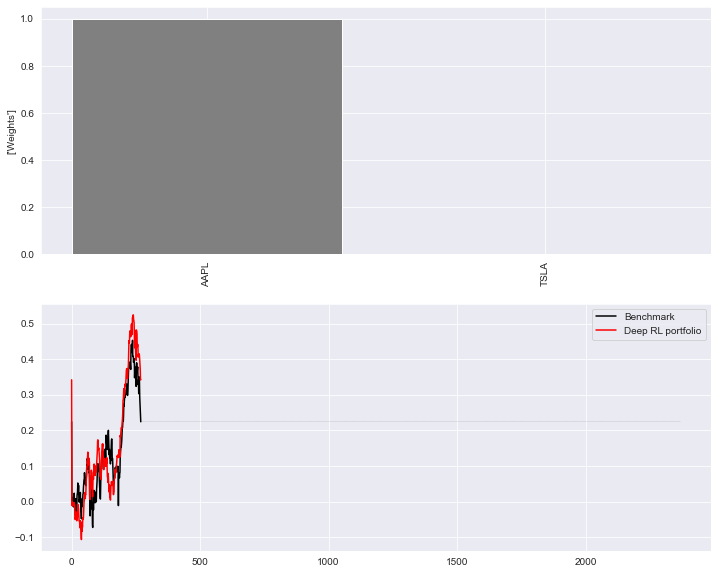

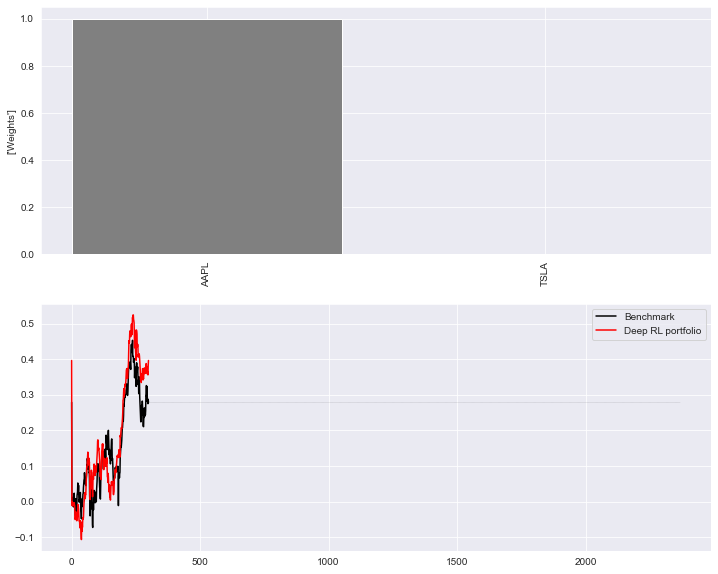

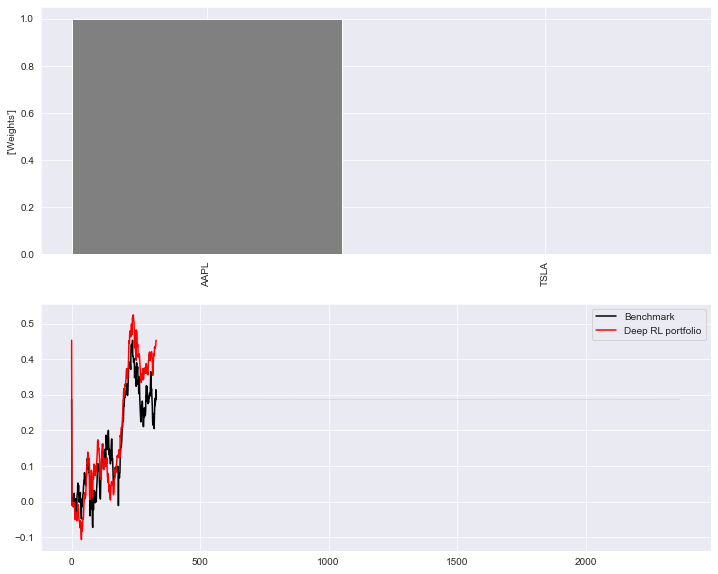

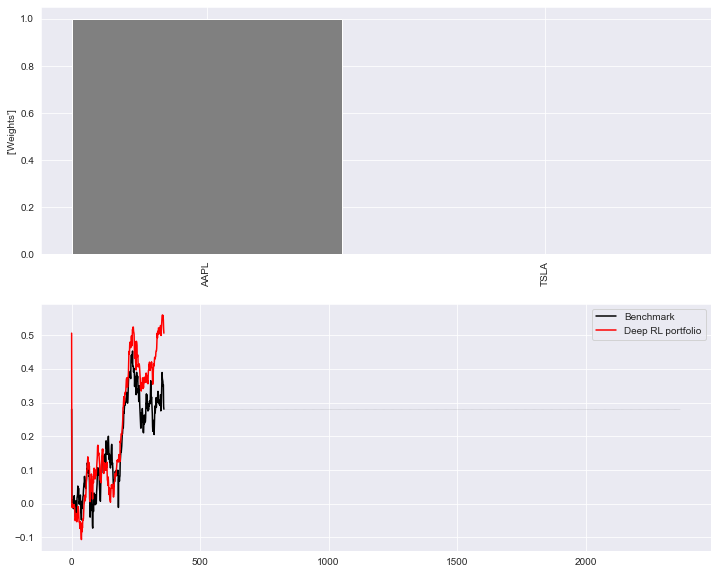

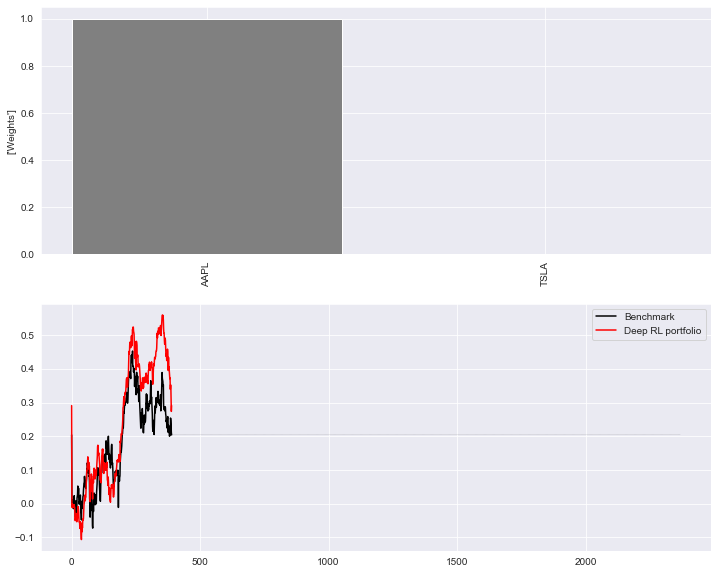

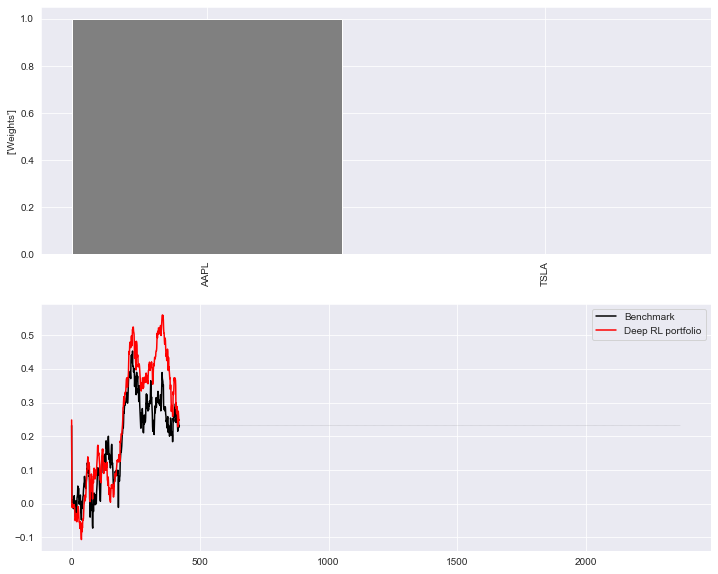

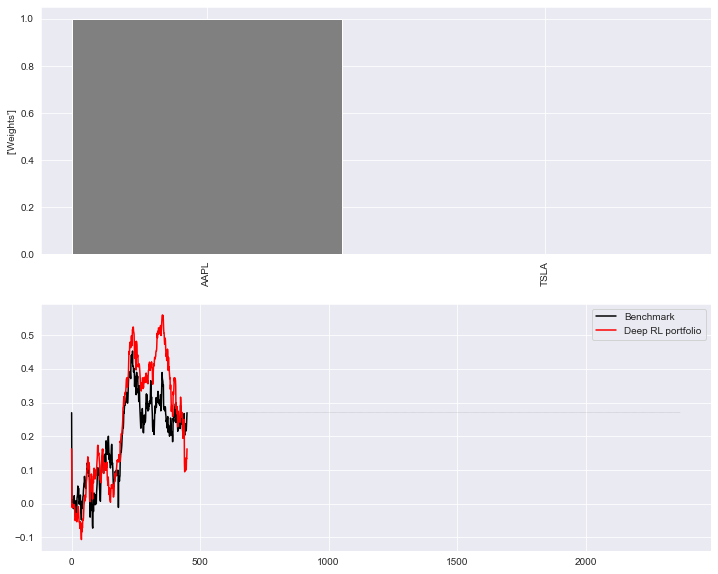

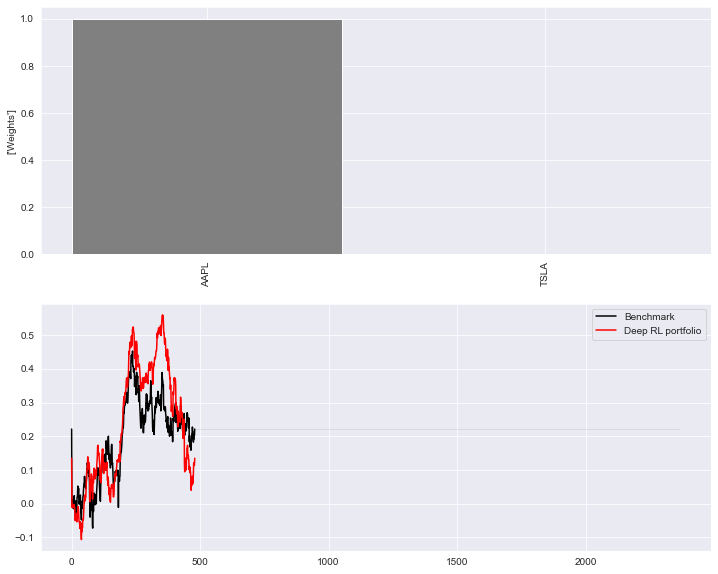

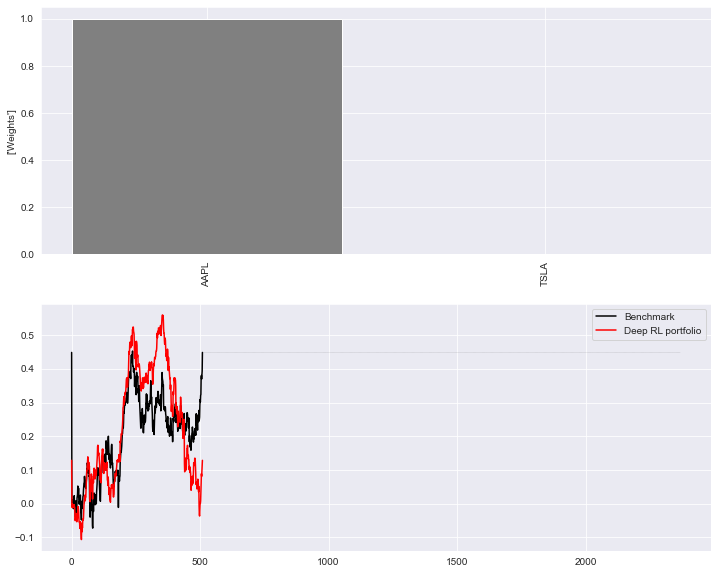

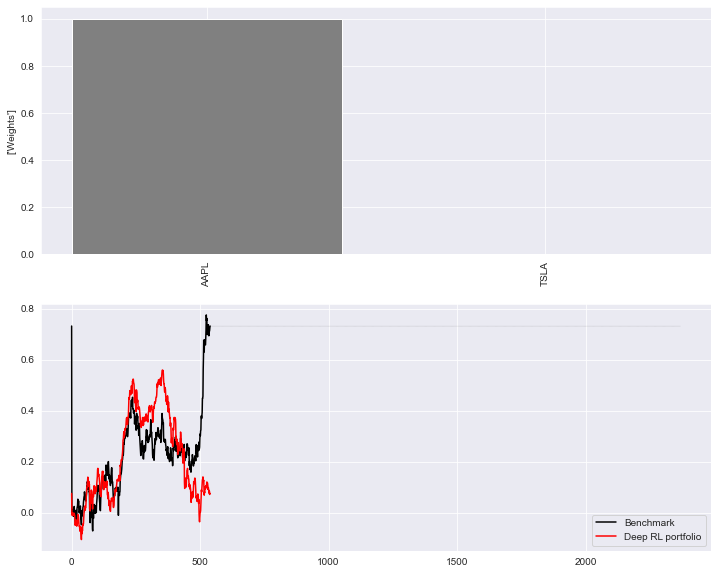

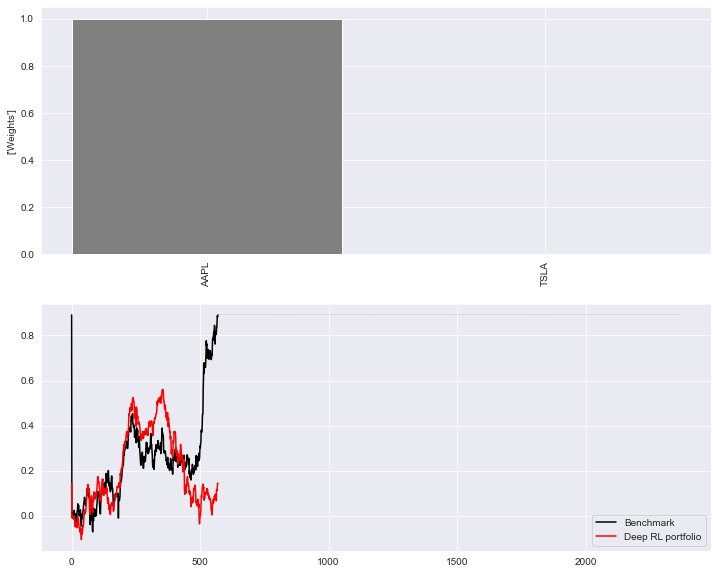

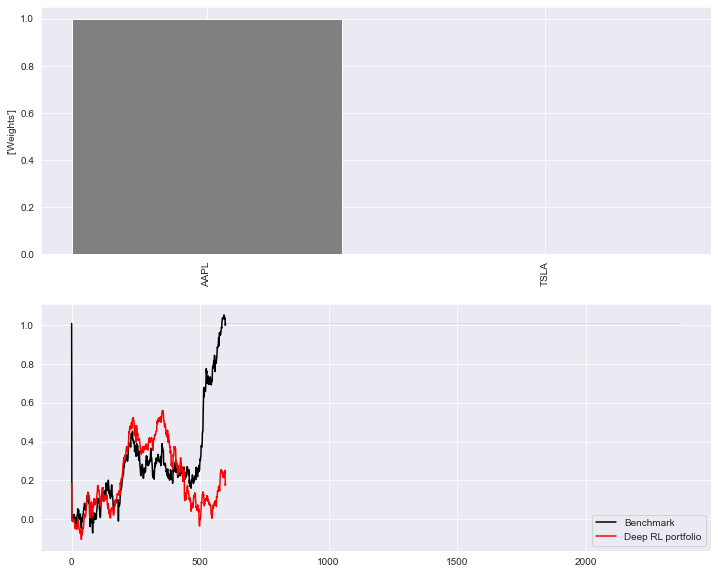

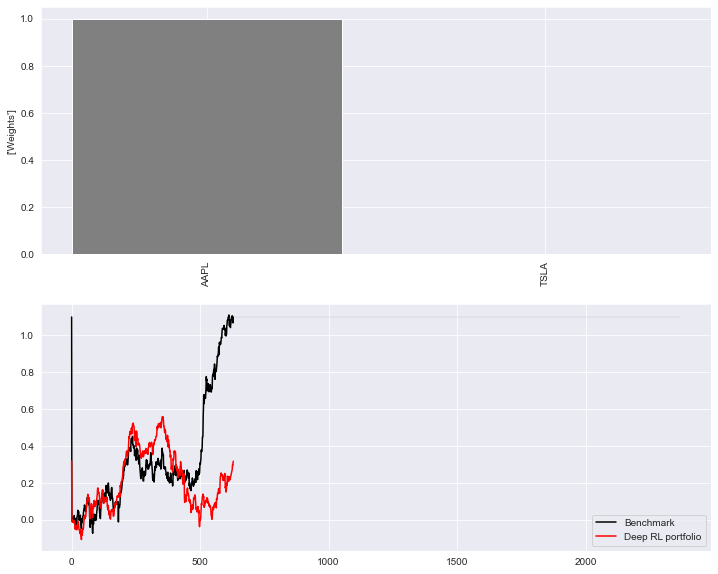

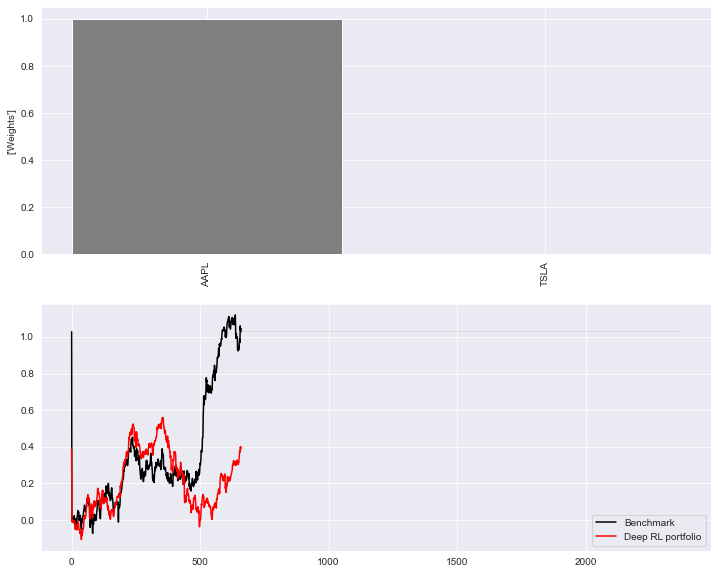

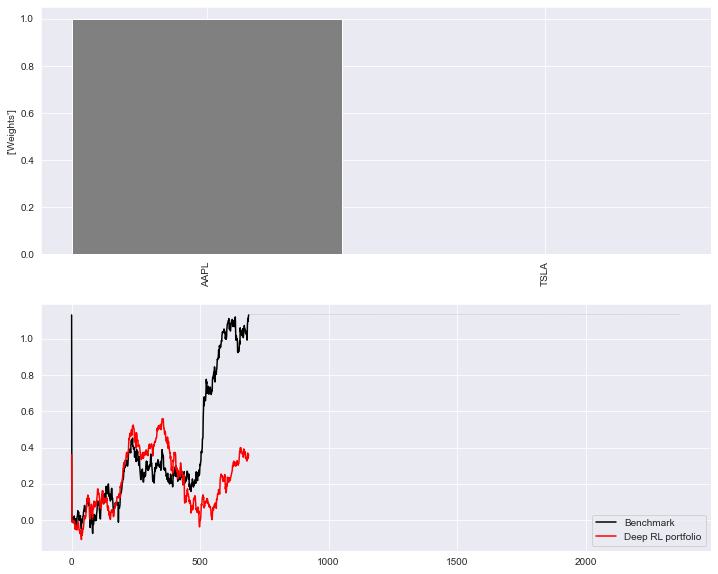

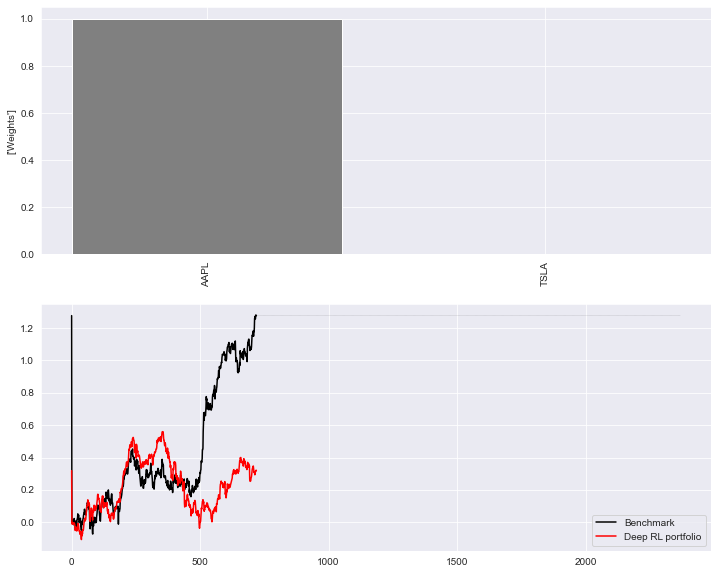

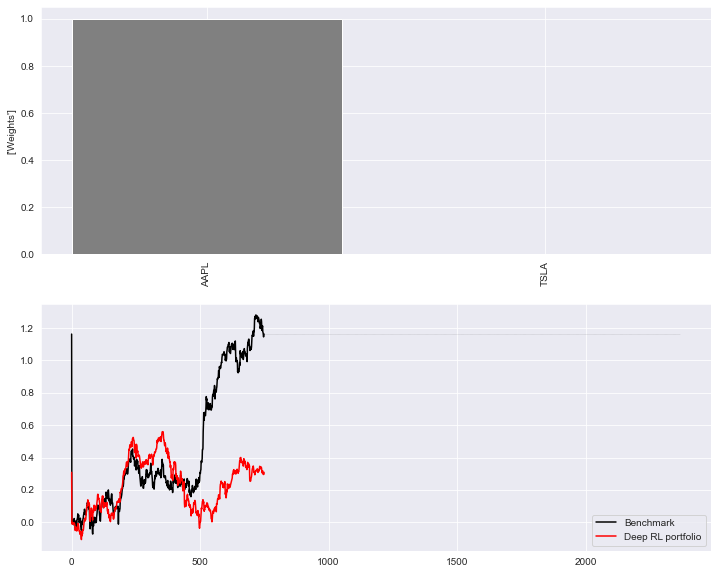

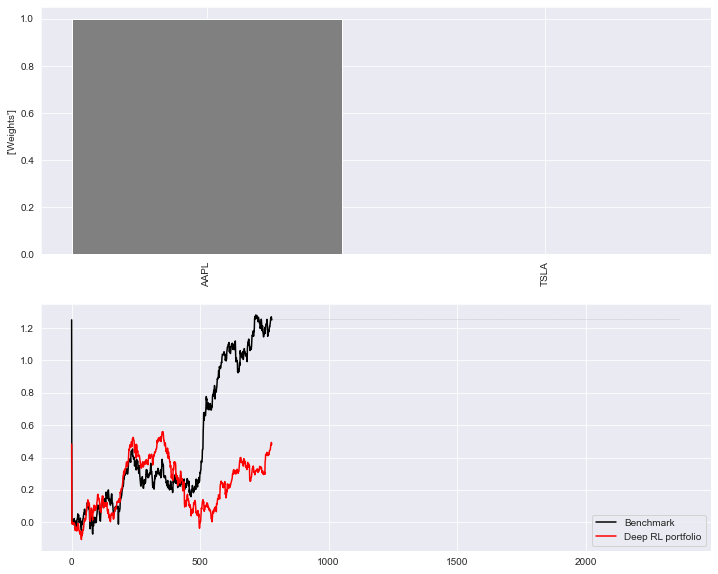

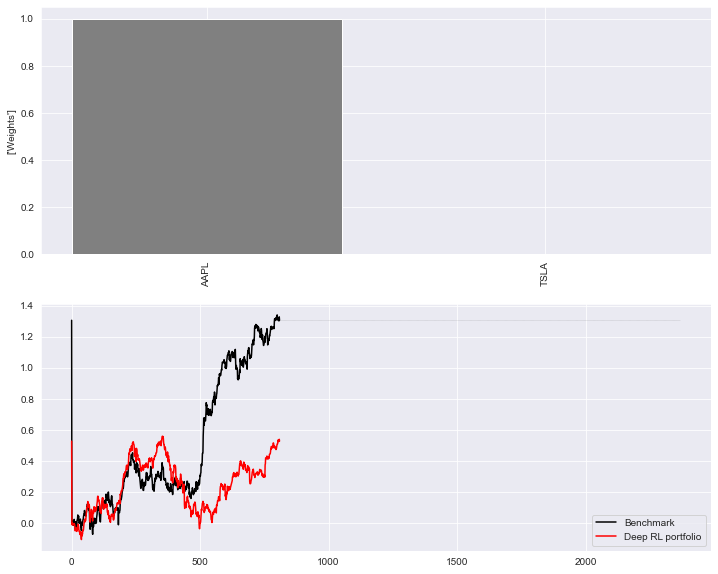

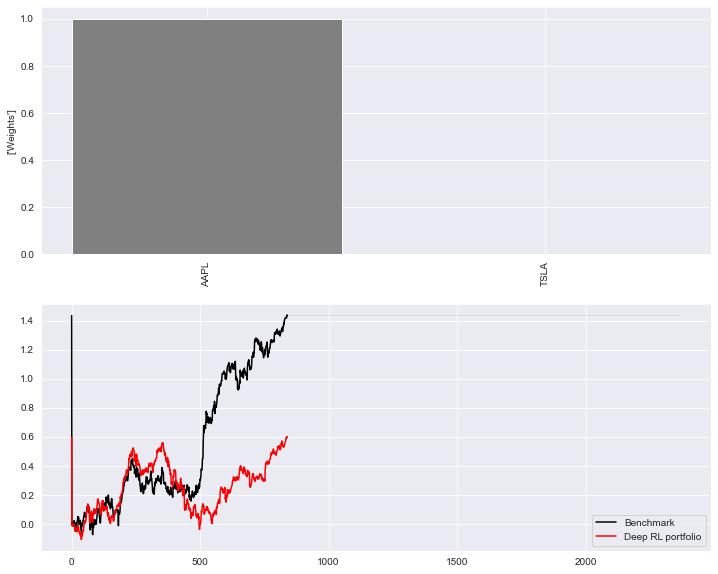

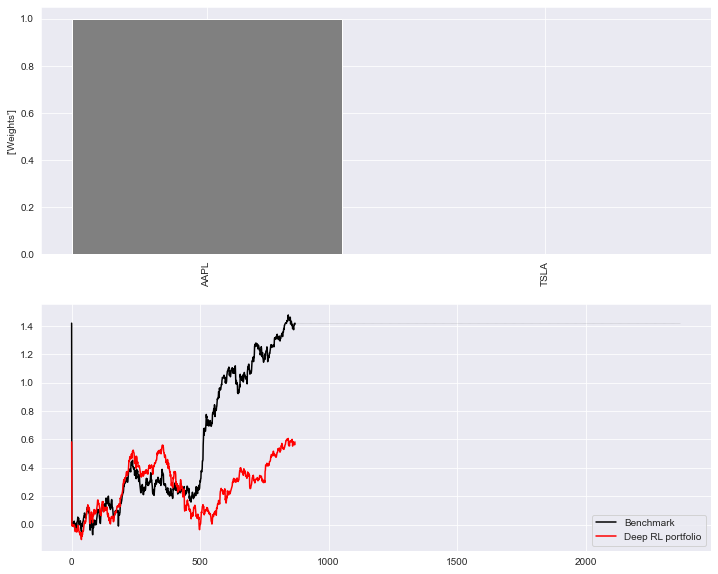

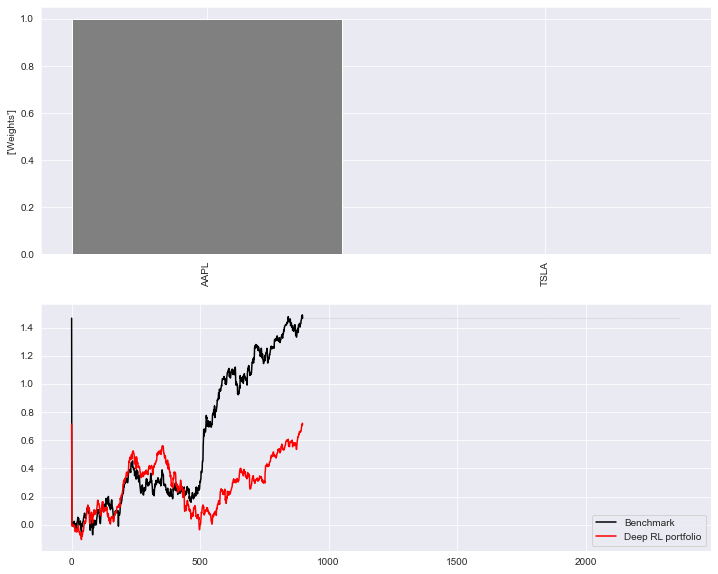

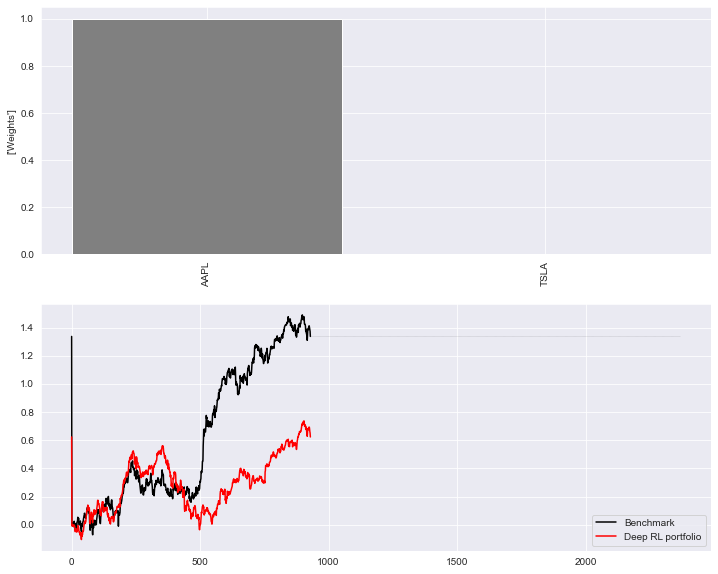

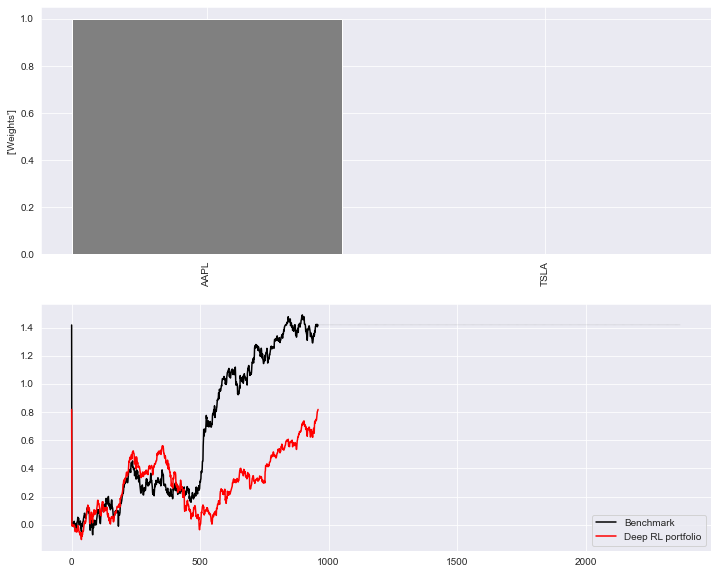

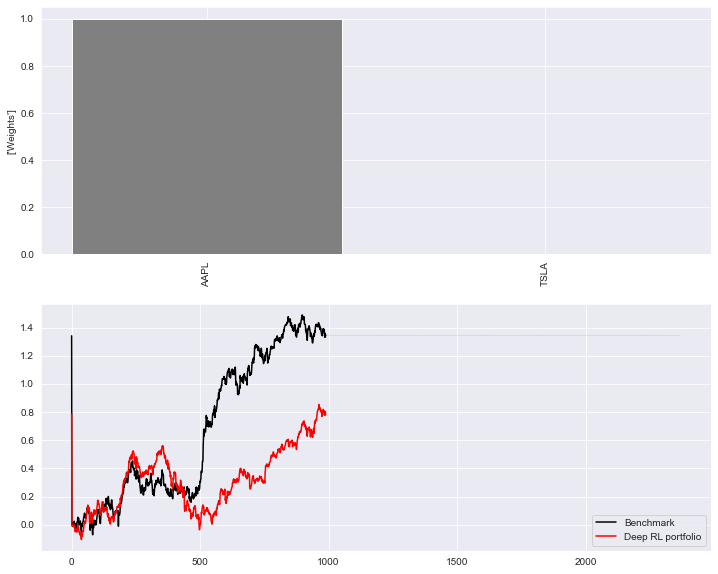

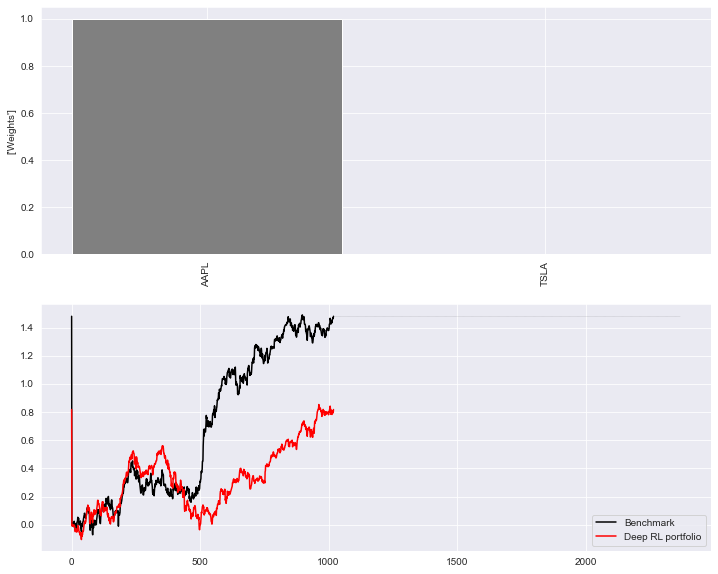

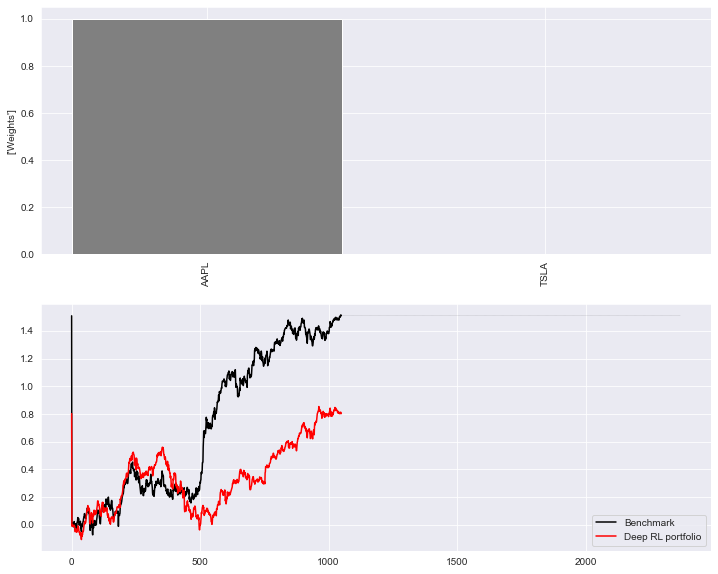

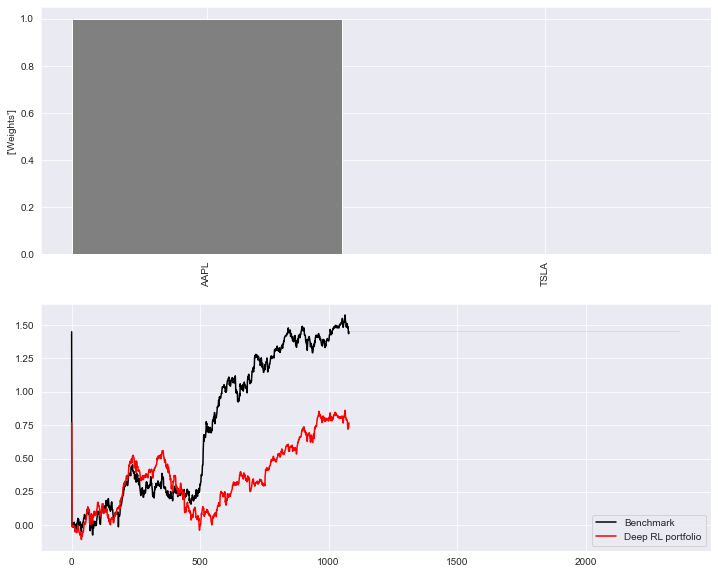

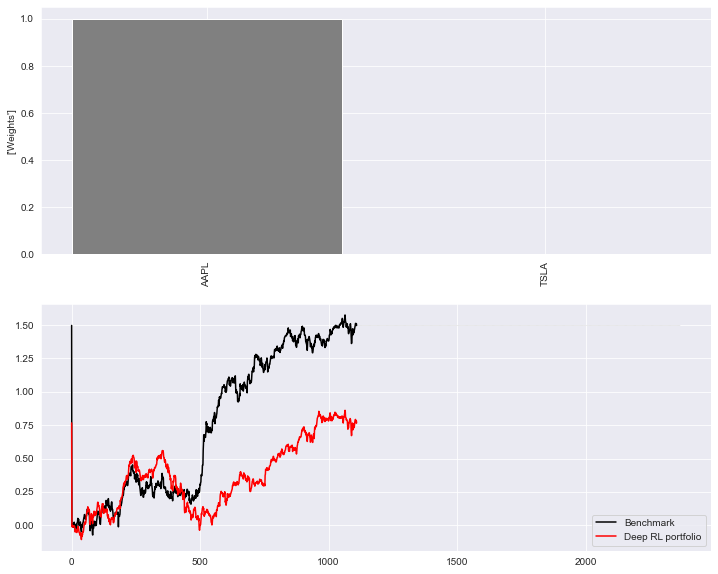

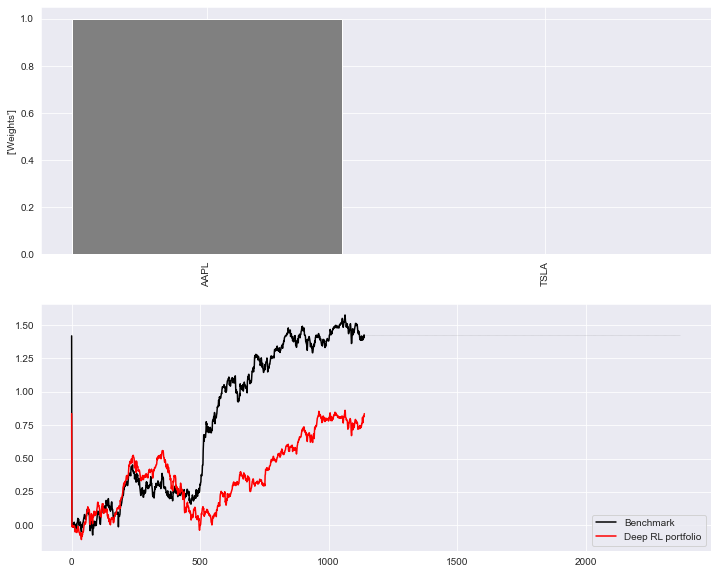

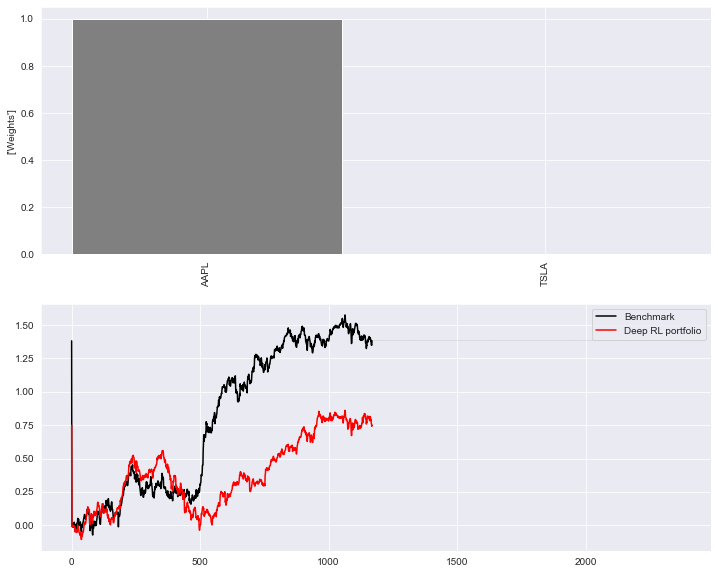

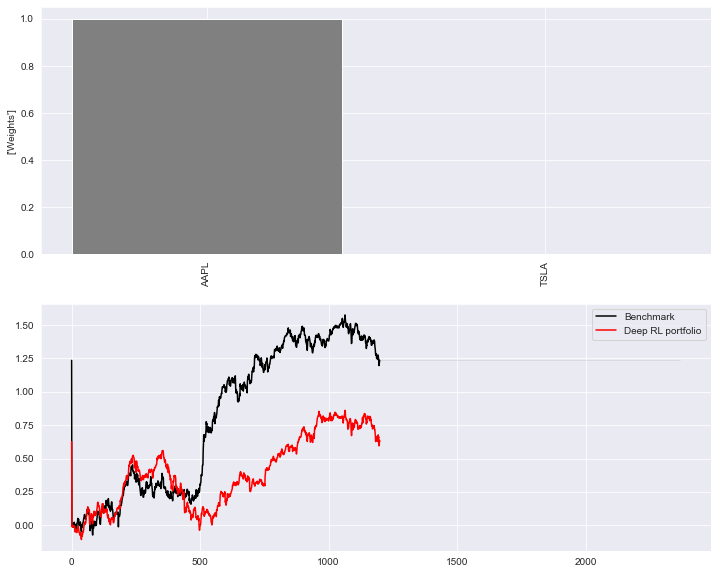

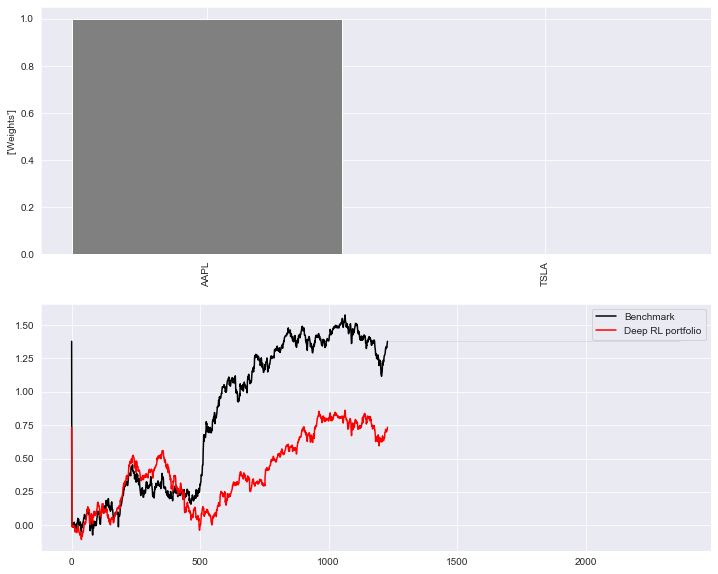

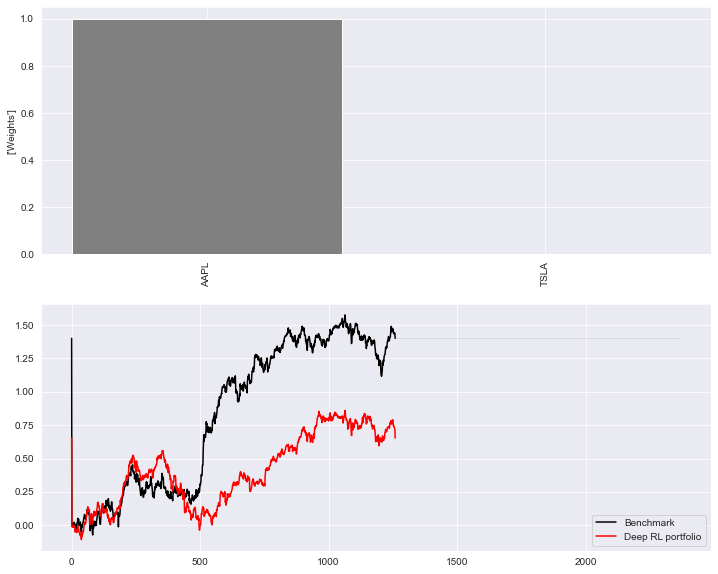

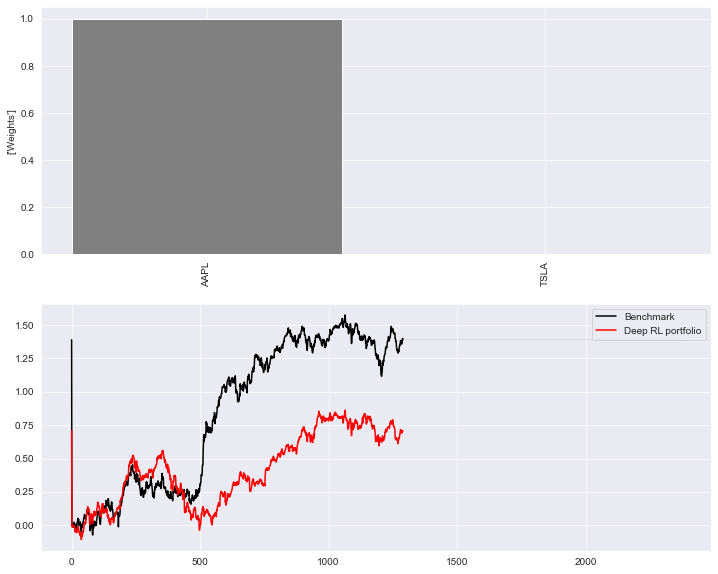

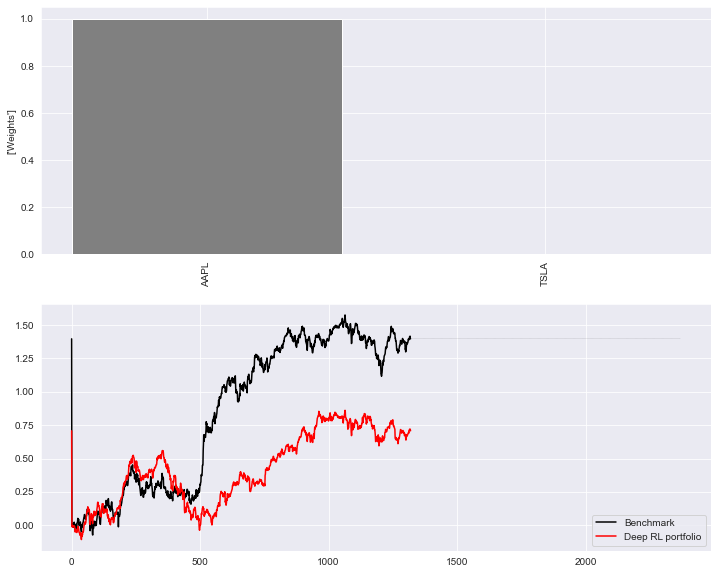

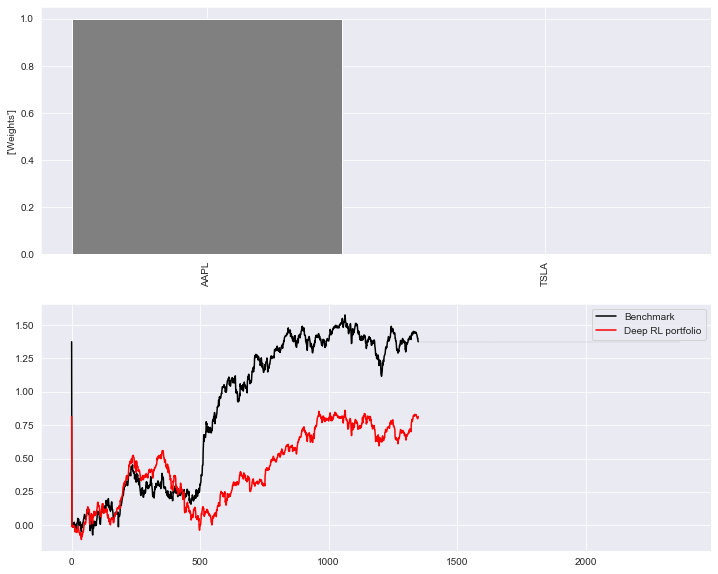

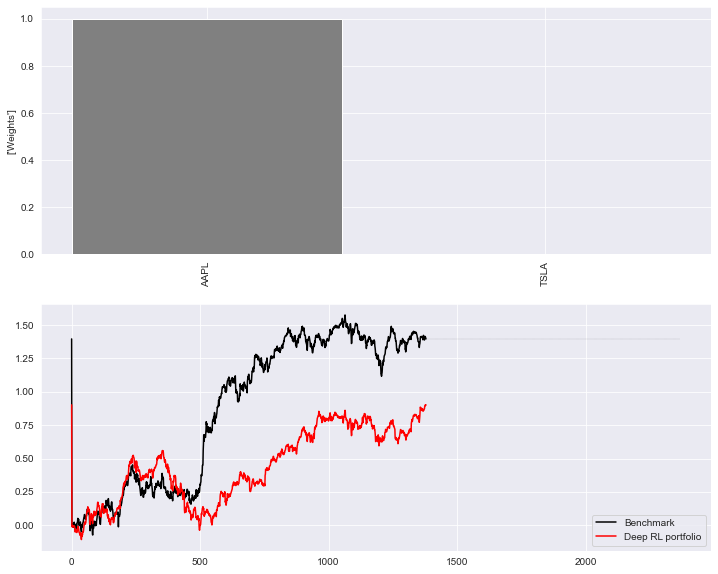

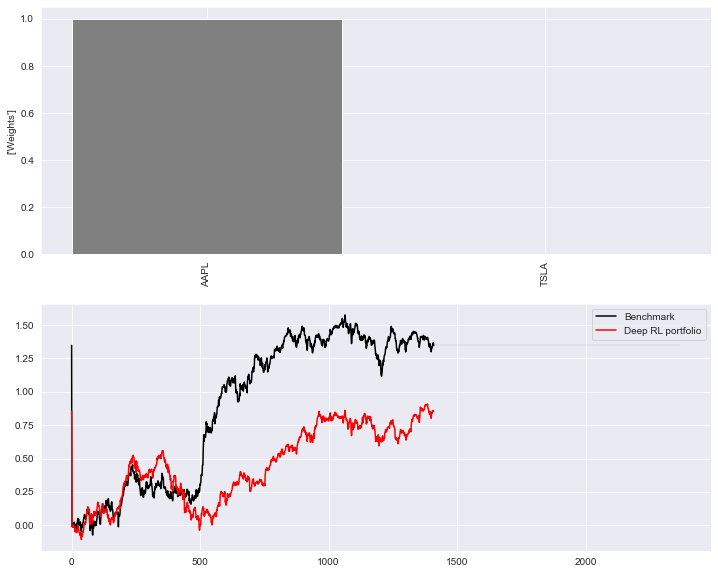

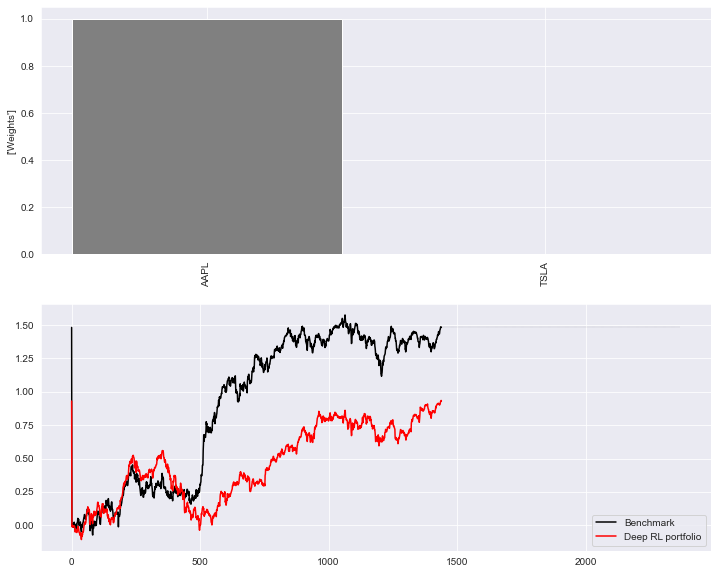

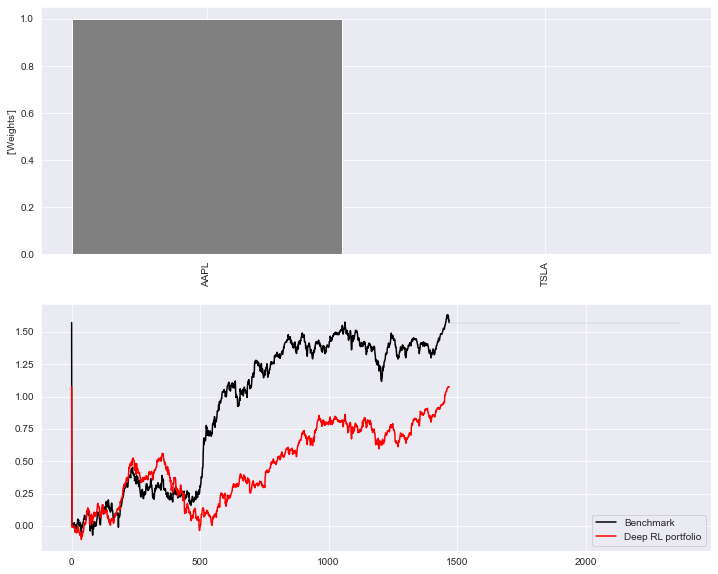

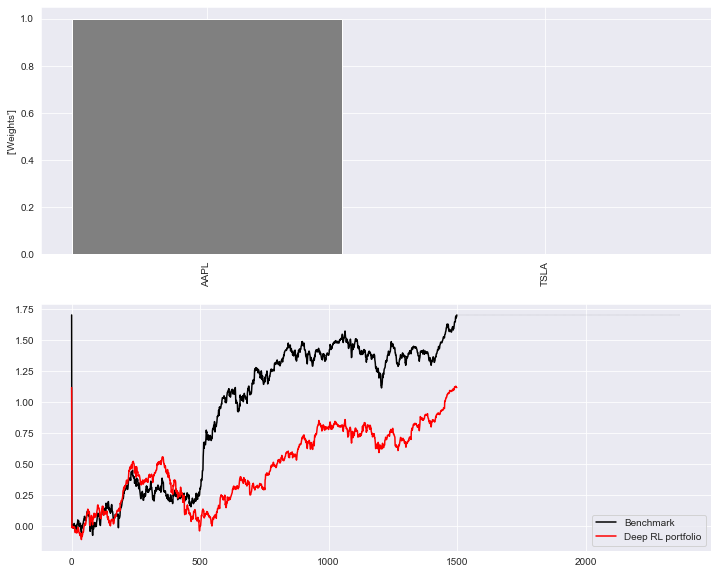

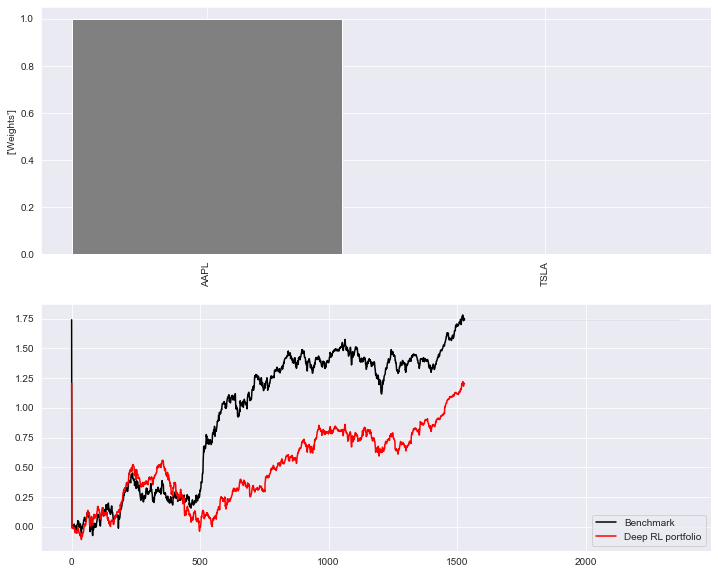

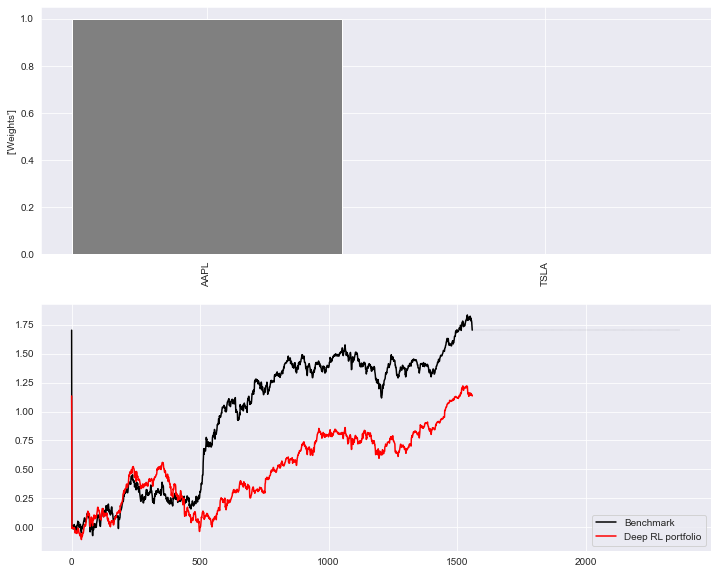

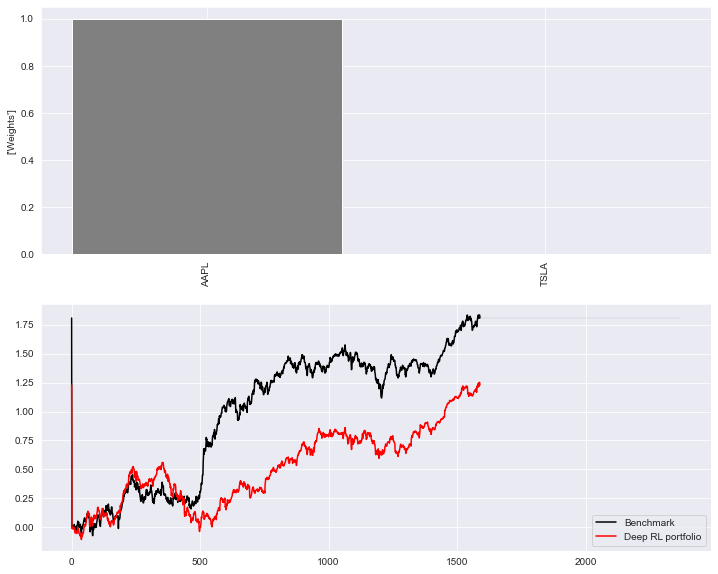

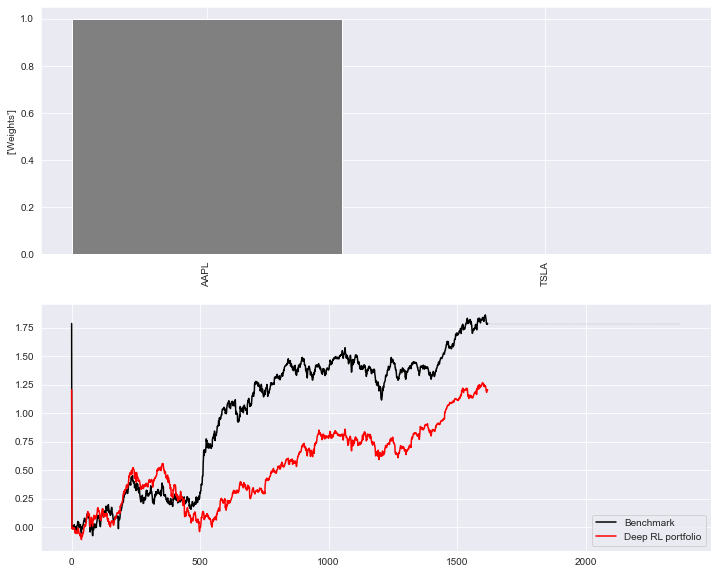

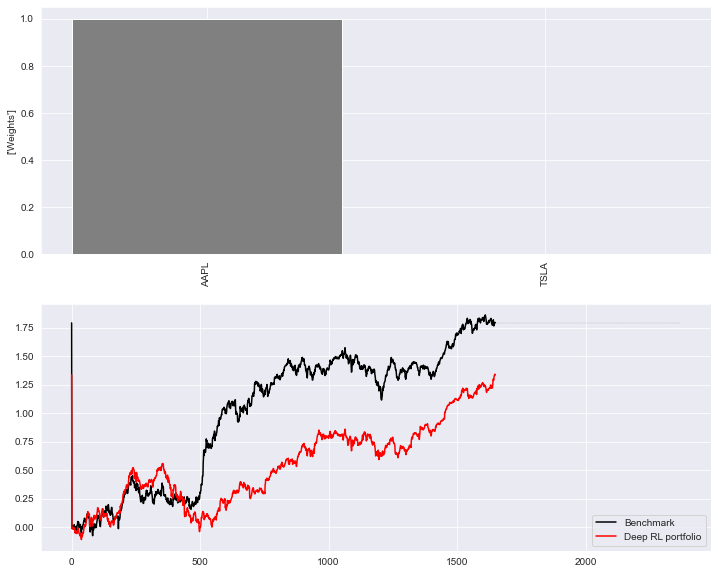

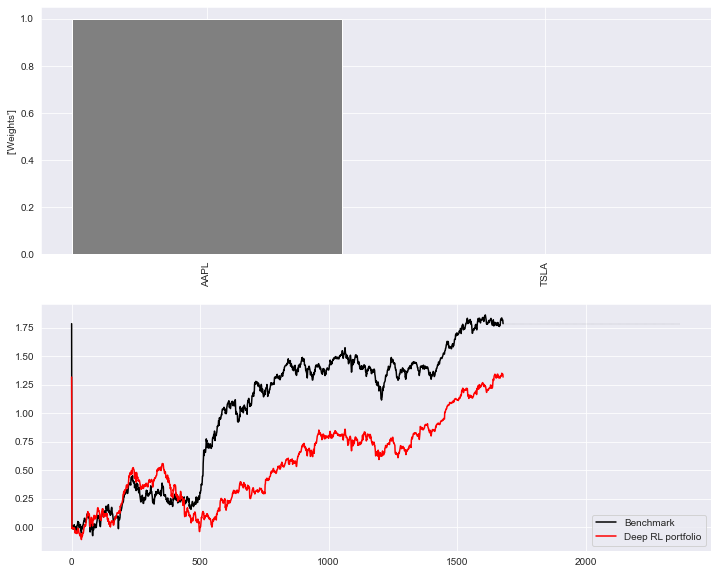

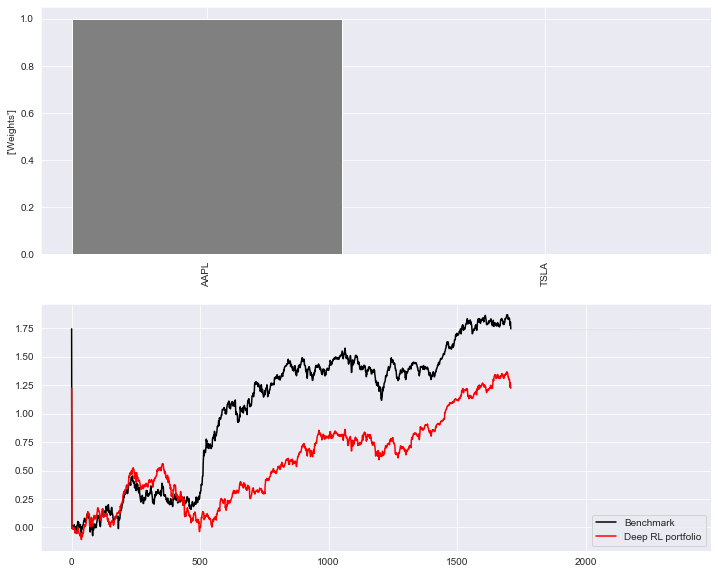

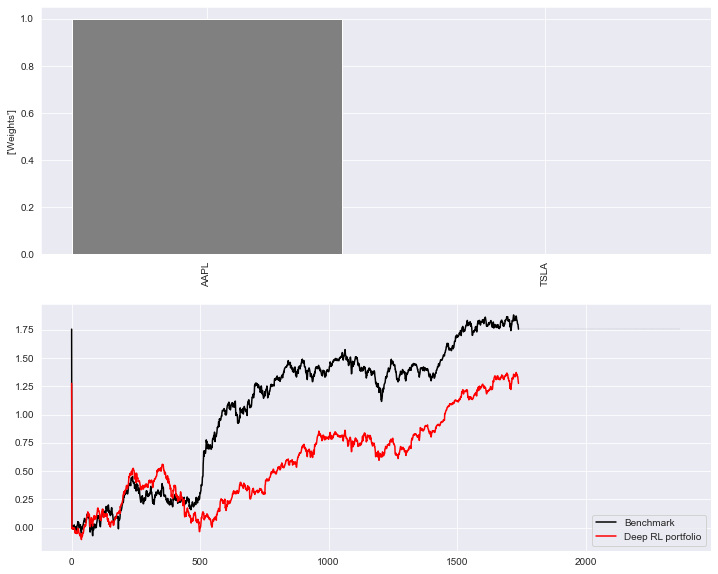

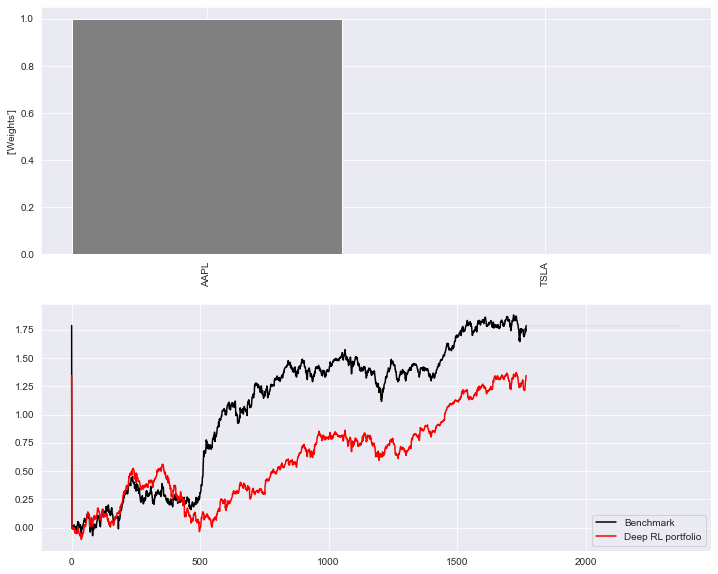

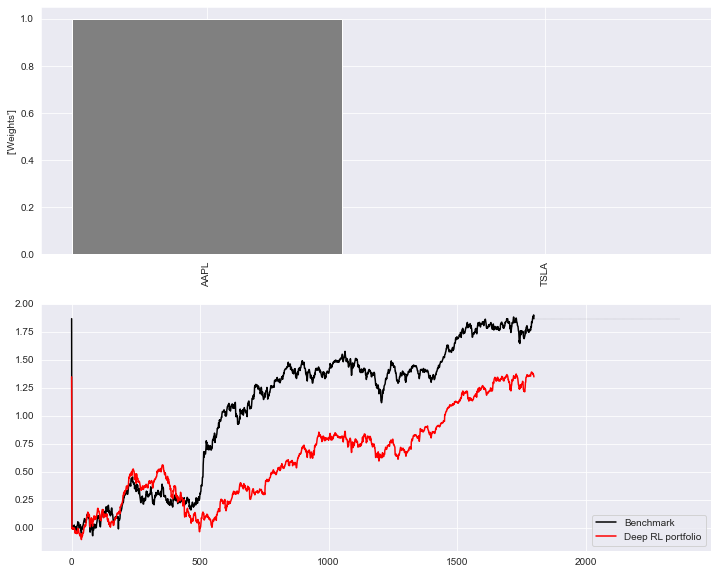

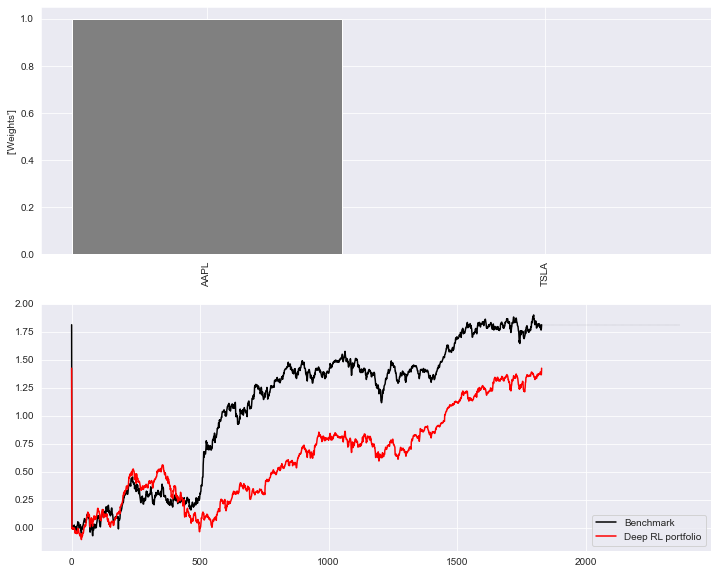

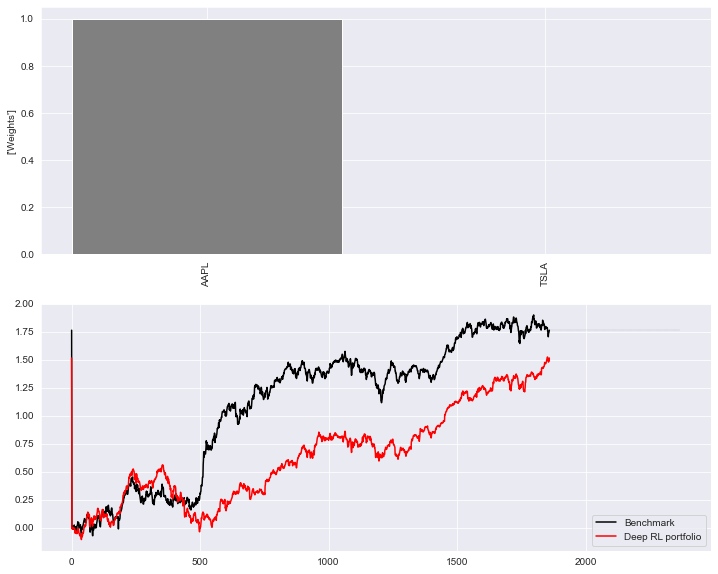

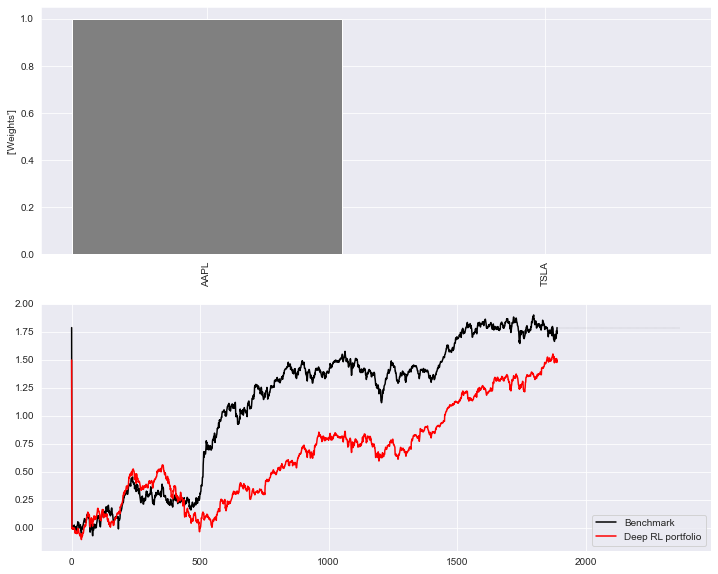

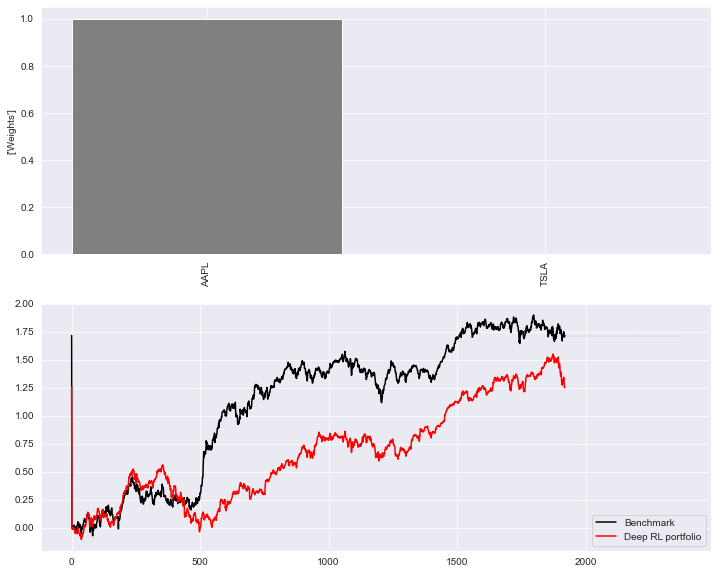

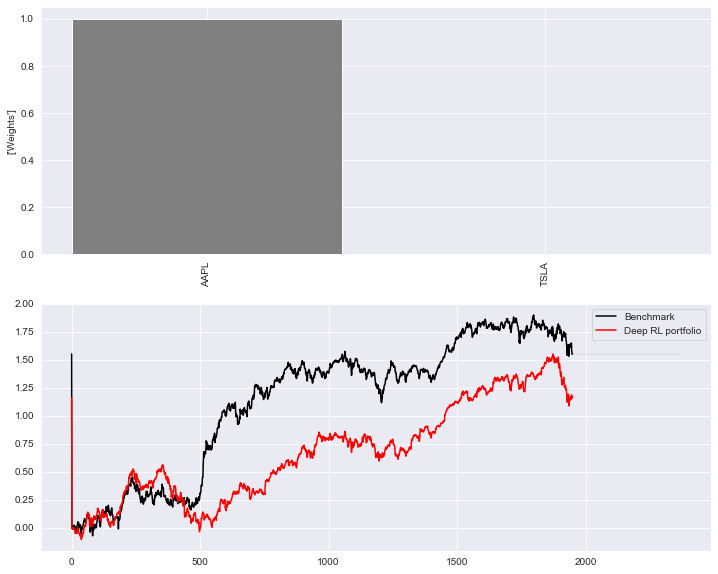

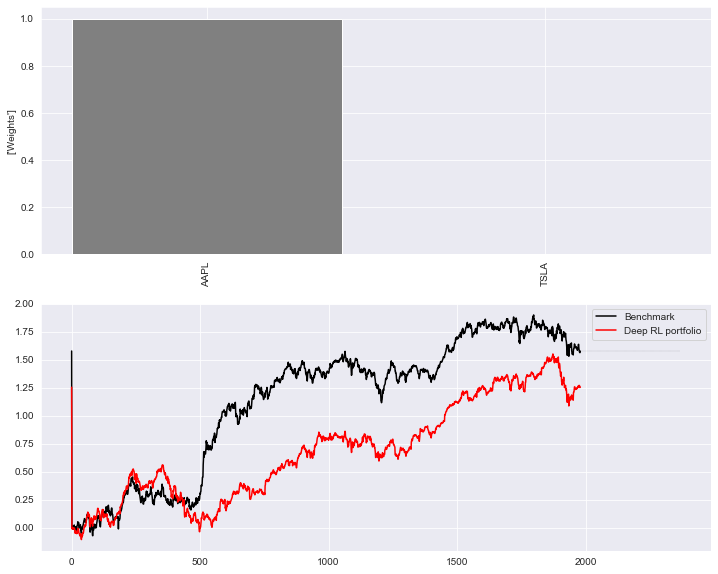

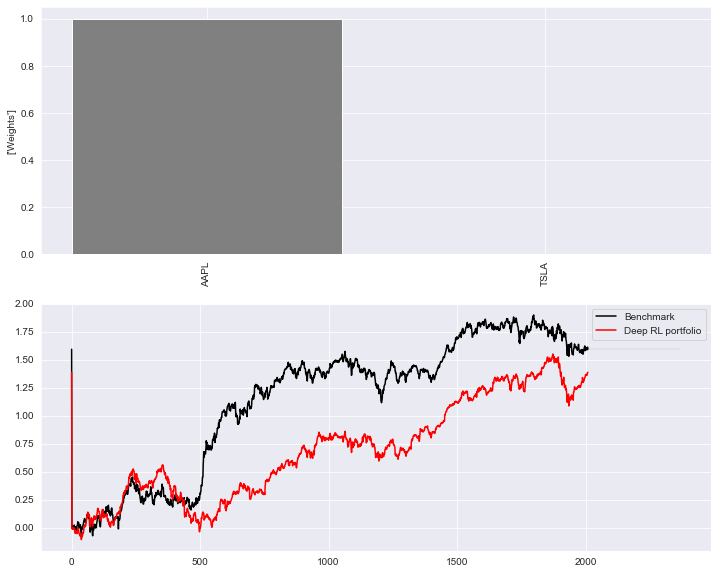

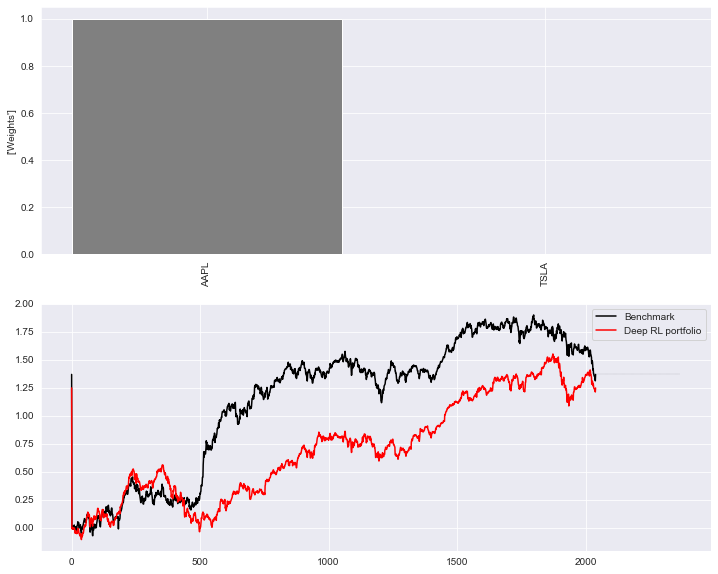

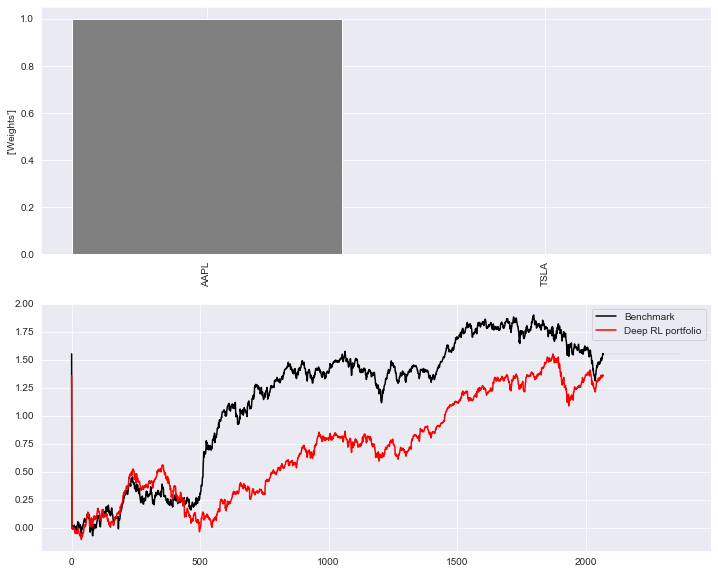

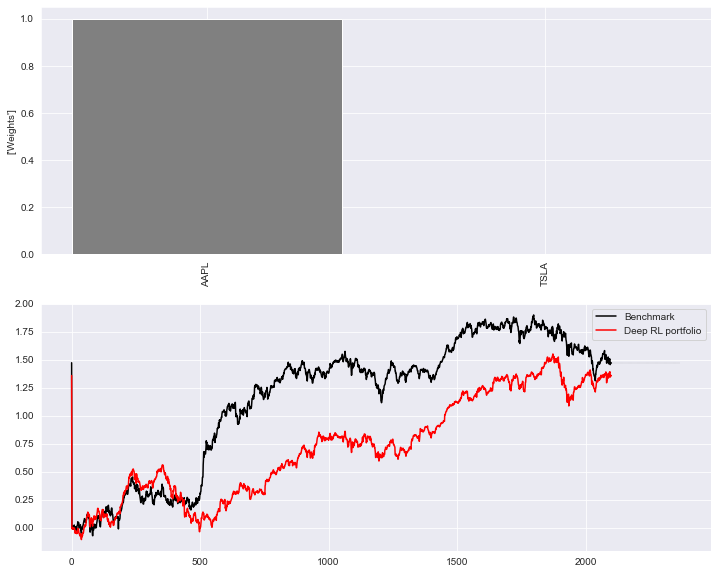

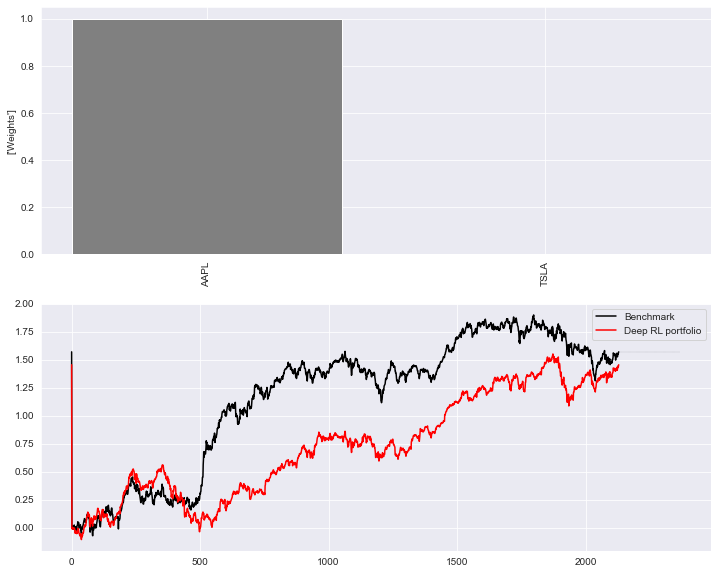

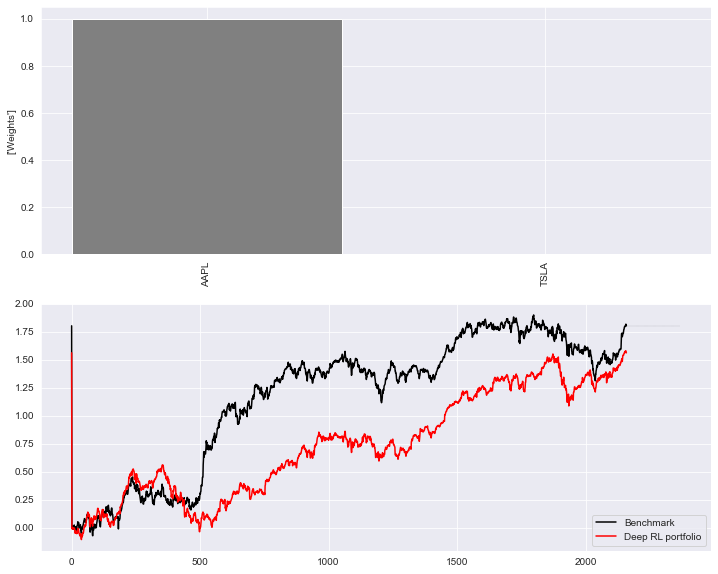

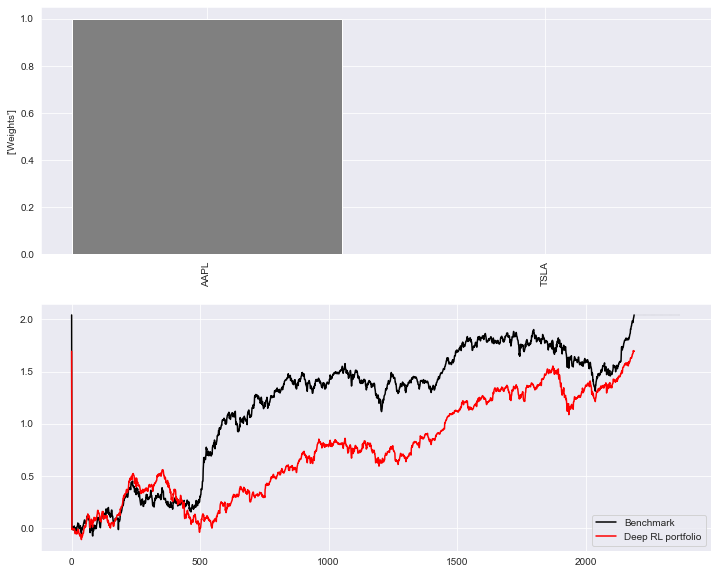

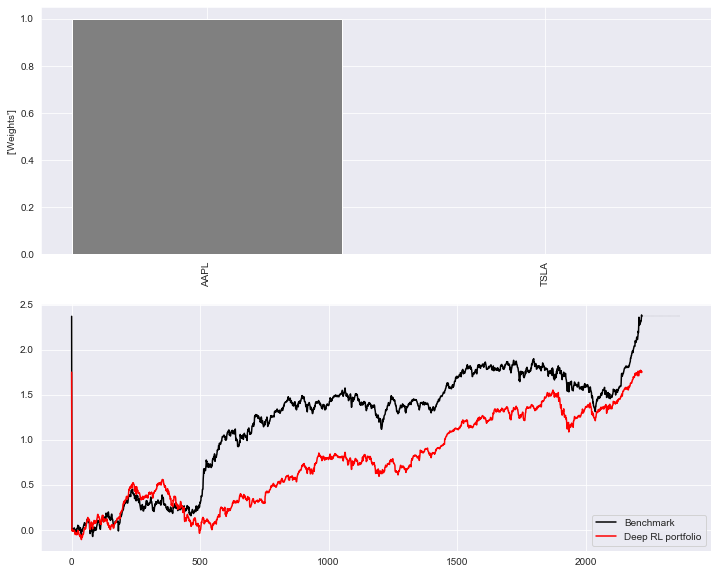

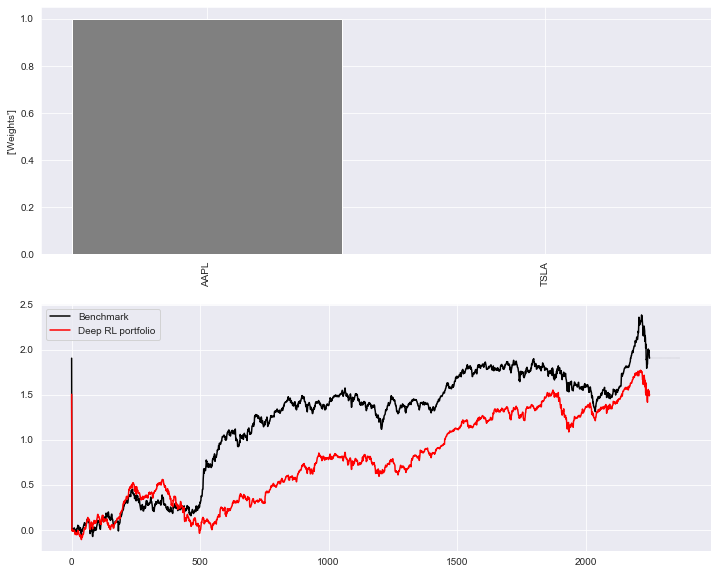

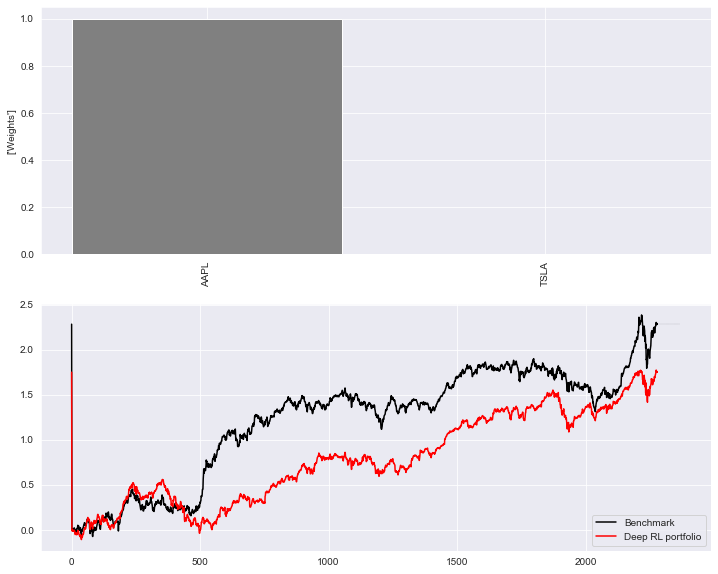

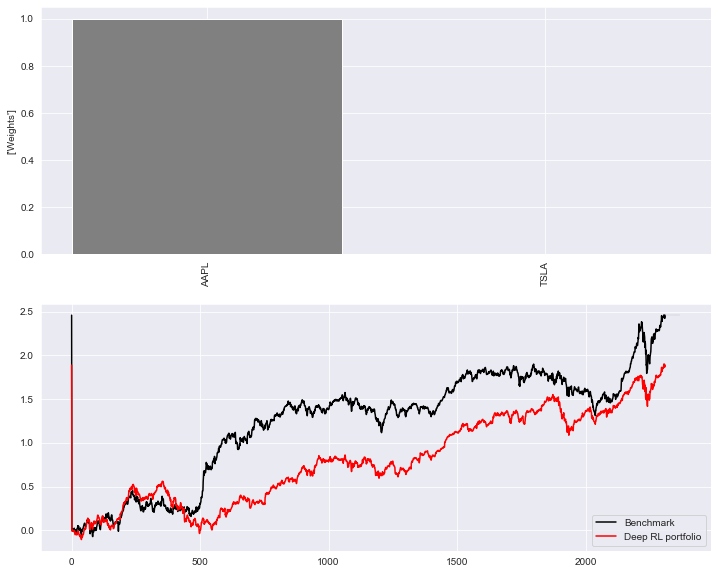

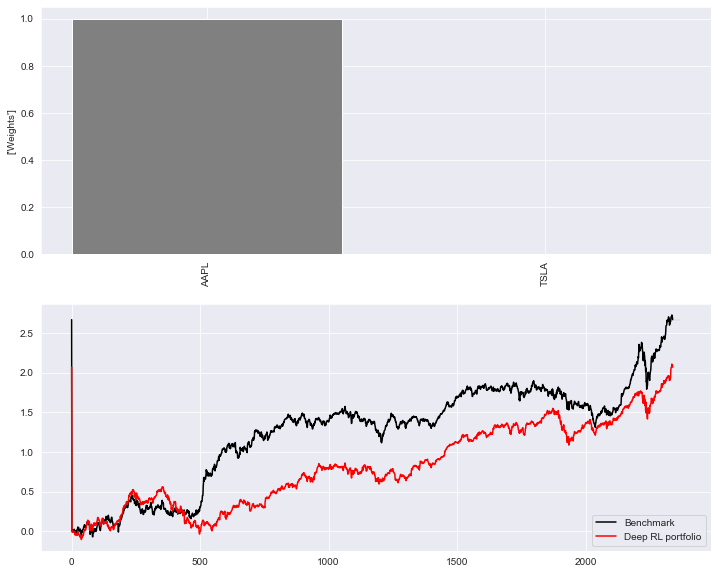

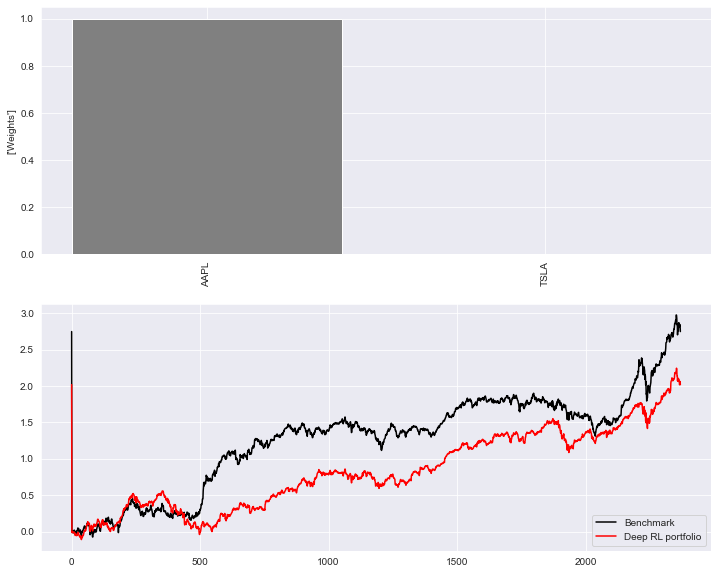

In [40]:
plot_results(benchmark_series=result_equal, 
             target_series=result_rl, 
             target_balances=actions_rl, 
             n_assets=N_ASSETS,
             columns=panel_data.columns, 
             name2plot='Deep RL portfolio',
             path2save='./images_test1/rl/',
             base_name_series='series')

In [32]:
# change elu to lstm/softmax
# change linear Dense layer to tanh or sigmoid
# change reward function to predicted stock prices or predicted SR

# END